# 🎬 Adaptive Video Search Engine

**자연어 쿼리 기반 지능형 비디오 검색 시스템**

이 노트북은 CLIP, BLIP-2, Gemini API를 활용한 비디오 검색 엔진을 구현합니다.

## 📋 주요 기능

1. **지능형 쿼리 분석**: Gemini API로 한국어 쿼리를 동작 시퀀스로 분할
2. **적응형 매칭 엔진**: CLIP 기반 유사도 계산 + 변곡점 탐지
3. **2단계 검색**: CLIP → BLIP-2 보정으로 정확도 향상
4. **실시간 시각화**: 검색 진행 상황을 그래프로 표시

## 📦 시작하기 전에

- GPU 사용 권장 (BLIP-2 사용 시)
- `.env` 파일에 `GEMINI_API_KEY` 설정 필요
- 비디오 파일 준비 (`sample_video.mp4`)


## 1. 패키지 설치

먼저 필요한 패키지들을 설치합니다.


In [9]:
%cd /content/YAI_17_Winter_Project

/content/YAI_17_Winter_Project


In [ ]:
%pip install transformers opencv-python pillow numpy google-genai python-dotenv matplotlib
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install triton
%pip install av --upgrade
print("필요한 패키지 설치가 끝났습니다.")

Looking in indexes: https://download.pytorch.org/whl/cu121
필요한 패키지 설치가 끝났습니다.


## 2. 라이브러리 Import


In [ ]:
import os
import torch
import torchvision.io as io
import torchvision.transforms.functional as F
import json
import datetime
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, Blip2Processor, Blip2ForConditionalGeneration
from typing import List
from google import genai
import json
import re
from dotenv import load_dotenv
import time
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, FancyBboxPatch
import shutil

print("✅ 모든 라이브러리 import 완료!")

✅ 모든 라이브러리 import 완료!


## 3. Gemini API 설정 & Model Manager

Gemini API 클라이언트를 초기화하고, CLIP 및 BLIP-2 모델을 관리하는 클래스를 정의합니다.


In [ ]:
# ==========================================
# Gemini API 설정 (AdaptiveSearchEngine 내부 혹은 외부에 선언)
# ==========================================
# .env 파일 로드
# load_dotenv()

# API 키는 환경변수
# GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

# 코랩 환경에서는 로딩이 다름
# 좌측 패널 열쇠 모양 클릭 -> 새 보안 비밀 추가 -> 이름: GEMINI_API_KEY, 값: 실제 API 키값 따옴표 없이 그대로.
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

# 캐글
# from kaggle_secrets import UserSecretsClient

# # API 키 가져오기
# user_secrets = UserSecretsClient()
# GEMINI_API_KEY = user_secrets.get_secret("GEMINI_API_KEY")

client = genai.Client(api_key=GEMINI_API_KEY, http_options=genai.types.HttpOptions(api_version="v1"))
if client is not None:
    print("Gemini Client initialized successfully")
else:
    print("Gemini Client initialization failed")
    exit()
# # 현재 사용 가능한 모든 모델 리스트 출력
# for model in client.models.list():
#     print(f"Model Name: {model.name}, Supported Methods: {model.supported_actions}")
# exit()

# ==========================================
# 1. Model Manager (CLIP & BLIP-2)
# ==========================================
class ModelManager:
    def __init__(self, use_blip=False, device=None):
        start_time = time.time()
        print("Initializing ModelManager...")
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Loading models on {self.device}...")

        # Load CLIP (Base Model)
        clip_start = time.time()
        self.clip_processor = CLIPProcessor.from_pretrained(
            "openai/clip-vit-base-patch32",
            use_fast=True  # 이 옵션을 추가하면 Rust 기반의 빠른 전처리기를 사용합니다.
        )
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(self.device)
        self.clip_model.eval()
        clip_time = time.time() - clip_start
        print(f"CLIP Model loaded ({clip_time:.2f}초)")

        # Load BLIP-2 (Refinement Model) - Optional
        self.use_blip = use_blip
        self.blip_processor = None
        self.blip_model = None
        blip_time = 0.0

        if self.use_blip:
            print("Loading BLIP-2 (this might take memory)...")
            blip_start = time.time()
            self.blip_processor = Blip2Processor.from_pretrained(
                "Salesforce/blip2-opt-2.7b",
                use_fast=True)
            self.blip_model = Blip2ForConditionalGeneration.from_pretrained(
                "Salesforce/blip2-opt-2.7b", dtype=torch.float16,
                device_map={"": self.device} # 현재 지정된 GPU 장치에만 할당
            ).to(self.device)
            self.blip_model.eval()
            blip_time = time.time() - blip_start
            print(f"BLIP-2 Model loaded ({blip_time:.2f}초)")

        self.init_time = time.time() - start_time
        self.clip_load_time = clip_time
        self.blip_load_time = blip_time
        print(f"ModelManager 초기화 완료 (총 {self.init_time:.2f}초)")


    def get_clip_scores(self, images: List[Image.Image], text_queries: List[str]) -> np.ndarray:
        """
        Computes cosine similarity matrix between images and texts.
        Returns: (n_images, n_queries) numpy array
        """
        inputs = self.clip_processor(text=text_queries, images=images, return_tensors="pt", padding=True).to(self.device)
        with torch.no_grad():
            outputs = self.clip_model(**inputs)
            # 특징 벡터(Embedding)를 직접 가져와서 정규화 후 코사인 유사도 계산
            image_embeds = outputs.image_embeds / outputs.image_embeds.norm(p=2, dim=-1, keepdim=True)
            text_embeds = outputs.text_embeds / outputs.text_embeds.norm(p=2, dim=-1, keepdim=True)

            # 코사인 유사도 (0.0 ~ 1.0)
            cosine_sim = torch.matmul(image_embeds, text_embeds.T)
        return cosine_sim.cpu().numpy()

    def generate_caption(self, image: Image.Image, prompt: str = None) -> str:
        """
        Generates caption using BLIP-2 with optional prompt

        Args:
            image: PIL Image
            prompt: 힌트로 사용할 쿼리 (선택)

        Returns:
            생성된 캡션
        """
        if not self.use_blip:
            return ""

        if prompt:
            # 프롬프트를 "힌트"로 활용하는 instruction 생성
            # BLIP-2는 영어 instruction이 더 효과적
            instruction = f"Based on the hint '{prompt}', this image shows"
            inputs = self.blip_processor(images=image, text=instruction, return_tensors="pt").to(self.device, torch.float16)
        else:
            # 기존 방식 (프롬프트 없음)
            inputs = self.blip_processor(images=image, return_tensors="pt").to(self.device, torch.float16)

        generated_ids = self.blip_model.generate(
            **inputs,
            max_new_tokens=40, # 너무 길면 헛소리 할 수 있음
            min_length=10,
            num_beams=5,       # Beam Search로 퀄리티 향상
            no_repeat_ngram_size=3,   # 3단어 이상 반복되면 강제로 차단 (강력 추천)
            repetition_penalty=1.2,   # 1.5는 너무 높으니 1.1~1.2 정도로 완화
            early_stopping=True       # 문장이 완성되면 일찍 끝냄
        )

        # 반환 값에는 제공한 프롬프트가 있으면 안 됨
        raw_answer = self.blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        # "detail:" 이후의 텍스트만 포함해야 함 (문장 분리 후 첫 번째 문장)
        search_str = ", this image shows"
        detail_start = raw_answer.find(search_str)
        if detail_start != -1:
            modified_answer = raw_answer[detail_start + len(search_str):].strip()
        else:
            modified_answer = raw_answer
        return modified_answer.strip()

    def get_text_features(self, text_list: List[str]):
        """텍스트를 CLIP 벡터로 변환 (텍스트 간 유사도 비교용)"""
        inputs = self.clip_processor(
            text=text_list,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=77
        ).to(self.device)
        with torch.no_grad():
            outputs = self.clip_model.get_text_features(**inputs)

        # BaseModelOutputWithPooling에서 실제 텐서 추출
        if hasattr(outputs, 'pooler_output'):
            text_features = outputs.pooler_output
        elif hasattr(outputs, 'last_hidden_state'):
            text_features = outputs.last_hidden_state[:, 0]  # CLS token
        else:
            text_features = outputs

        return text_features / text_features.norm(dim=-1, keepdim=True)

    def compute_text_similarity(self, text1: str, text2: str) -> float:
        """두 텍스트 간의 시맨틱 유사도 계산"""
        feat1 = self.get_text_features([text1])
        feat2 = self.get_text_features([text2])
        sim = torch.matmul(feat1, feat2.T)
        return sim.item()

print("✅ ModelManager 클래스 정의 완료!")


Gemini Client initialized successfully
Gemini Client initialized successfully
✅ ModelManager 클래스 정의 완료!


## 4. Video Processor

비디오 파일을 로드하고 윈도우 기반으로 프레임을 추출하는 클래스입니다.


In [ ]:
# ==========================================
# 2. Video Processor
# ==========================================

class VideoProcessor:
    def __init__(self, video_path, device="cuda"):
        start_time = time.time()
        self.video_path = video_path
        self.device = device

        # 1. VideoReader 초기화
        # stream='video'로 설정하여 오디오 제외, 비디오 스트림만 타겟팅
        self.v_reader = io.VideoReader(video_path, "video")

        # 메타데이터 추출
        self.metadata = self.v_reader.get_metadata()
        self.fps = self.metadata['video']['fps'][0]

        # duration 계산 (방법 A: 메타데이터에서 계산)
        # VideoReader는 총 프레임 수를 직접 제공하지 않으므로,
        # 비디오를 한 번 순회하여 계산
        self.total_frames = 0
        self.v_reader.seek(0)
        try:
            for _ in self.v_reader:
                self.total_frames += 1
        except StopIteration:
            pass

        # duration = 총 프레임 수 / FPS
        self.duration = self.total_frames / self.fps if self.fps > 0 else 0

        # 다시 처음으로 되돌림
        self.v_reader.seek(0)

        self.init_time = time.time() - start_time
        print(f"✅ VideoProcessor 로드 완료 (FPS: {self.fps}, 총 프레임: {self.total_frames}, Duration: {self.duration:.2f}초, 초기화 시간: {self.init_time:.2f}초)")

    def extract_window_frames(self, start_sec, end_sec, num_samples_q, window_idx=None, total_windows=None):
        """
        특정 구간에서 q개의 프레임을 순차적으로 추출
        - 1920x1080 이하: 원본 해상도 유지 (프로세서가 리사이징)
        - 1920x1080 초과: 메모리 보호를 위해 1080p로 다운스케일

        NOTE:
        기존 구현(각 샘플마다 seek 후 next 1장)은 비디오 인코딩/키프레임 간격/시간 해상도에 따라
        동일 프레임이 반복되는 현상이 발생할 수 있습니다.
        이를 방지하기 위해 start~end 구간을 한 번 seek 후 순차 디코딩하여 샘플링합니다.

        Args:
            start_sec: 시작 시간 (초)
            end_sec: 종료 시간 (초)
            num_samples_q: 추출할 프레임 수
            window_idx: 현재 윈도우 인덱스 (로깅용, optional)
            total_windows: 전체 윈도우 수 (로깅용, optional)
        """
        frames: list[Image.Image] = []
        if num_samples_q <= 0:
            return frames

        start_sec = float(start_sec)
        end_sec = float(end_sec)
        if end_sec <= start_sec:
            return frames

        # 1) 구간을 순차 디코딩으로 모은 뒤 샘플링
        decoded: list[Image.Image] = []
        eps = 1e-3

        # start로 정확히 seek (가능하면 keyframes_only=False)
        try:
            self.v_reader.seek(start_sec, keyframes_only=False)
        except TypeError:
            self.v_reader.seek(start_sec)
        except Exception as e:
            print(f"  ❌ seek 실패: {e}")
            return frames

        # window 길이에 비례해 최대 디코딩 프레임 수 제한 (무한 루프 방지)
        approx_frames_in_window = int(np.ceil((end_sec - start_sec) * float(self.fps))) if self.fps else 0
        max_decode = max(approx_frames_in_window + 10, num_samples_q + 2, 32)

        try:
            while len(decoded) < max_decode:
                frame_data = next(self.v_reader)
                if frame_data is None:
                    continue

                pts = frame_data.get("pts", None)
                if pts is not None:
                    try:
                        pts_f = float(pts)
                    except Exception:
                        pts_f = None

                    if pts_f is not None:
                        if pts_f < start_sec - eps:
                            continue
                        if pts_f > end_sec + eps:
                            break

                # frame_data['data']는 [C, H, W] uint8 텐서
                img_tensor = frame_data["data"]
                _, h, w = img_tensor.shape

                # 너무 큰 화질만 리사이징
                if min(h, w) > 1080:
                    scale = 1080 / max(h, w)
                    new_h, new_w = int(h * scale), int(w * scale)
                    resized_tensor = F.resize(img_tensor, [new_h, new_w], antialias=True)
                    del img_tensor
                    img_tensor = resized_tensor

                img = Image.fromarray(img_tensor.permute(1, 2, 0).byte().cpu().numpy())
                decoded.append(img)
                del img_tensor

                if len(decoded) == 1 and window_idx is not None:
                    print(f"  ✅ [Window {window_idx}/{total_windows}] [{start_sec:.1f}s] 첫 프레임 디코딩 성공!")

        except StopIteration:
            pass
        except Exception as e:
            print(f"  ❌ 프레임 디코딩 중 에러 발생: {e}")

        if not decoded:
            print(f"  ⚠️ [{start_sec:.1f}s-{end_sec:.1f}s] 구간에서 디코딩된 프레임이 없습니다.")
            return frames

        # 2) 디코딩된 프레임들에서 q개 균등 샘플링
        L = len(decoded)
        if num_samples_q >= L:
            # 부족하면 마지막 프레임 반복 (불가피)
            frames = decoded + [decoded[-1]] * (num_samples_q - L)
        else:
            idxs = np.linspace(0, L - 1, num_samples_q, dtype=int)
            frames = [decoded[i] for i in idxs.tolist()]

        return frames


    def iter_frames(self, stride=1, start_sec=0.0, end_sec=None):
        """
        전체 영상에서 일정 stride로 프레임을 순차 추출 (timestamp 포함)
        """
        stride = max(1, int(stride))
        start_sec = float(start_sec)
        end_sec = self.duration if end_sec is None else float(end_sec)
        eps = 1e-3

        # start로 정확히 seek (가능하면 keyframes_only=False)
        try:
            self.v_reader.seek(start_sec, keyframes_only=False)
        except TypeError:
            self.v_reader.seek(start_sec)
        except Exception as e:
            print(f"  ❌ seek 실패: {e}")
            return

        frame_idx = 0
        while True:
            try:
                frame_data = next(self.v_reader)
            except StopIteration:
                break

            if frame_data is None:
                frame_idx += 1
                continue

            pts = frame_data.get("pts", None)
            t = None
            if pts is not None:
                try:
                    t = float(pts)
                except Exception:
                    t = None

            if t is None and self.fps and self.fps > 0:
                t = start_sec + (frame_idx / self.fps)

            if t is not None:
                if t < start_sec - eps:
                    frame_idx += 1
                    continue
                if t > end_sec + eps:
                    break

            if frame_idx % stride != 0:
                frame_idx += 1
                continue

            # frame_data['data']는 [C, H, W] uint8 텐서
            img_tensor = frame_data["data"]
            _, h, w = img_tensor.shape

            # 너무 큰 화질만 리사이징
            if min(h, w) > 1080:
                scale = 1080 / max(h, w)
                new_h, new_w = int(h * scale), int(w * scale)
                resized_tensor = F.resize(img_tensor, [new_h, new_w], antialias=True)
                del img_tensor
                img_tensor = resized_tensor

            img = Image.fromarray(img_tensor.permute(1, 2, 0).byte().cpu().numpy())
            del img_tensor

            yield t, img
            frame_idx += 1
    def clear_memory(self):
        """
        4. 메모리 관리: 사용하지 않는 텐서 정리 및 캐시 비우기
        """
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    def get_timestamp_str(self, seconds):
        return str(datetime.timedelta(seconds=int(seconds)))

print("✅ VideoProcessor 클래스 정의 완료!")

✅ VideoProcessor 클래스 정의 완료!


## 5. Real-time Visualization

검색 진행 상황을 실시간으로 그래프에 표시하고 이미지로 저장하는 클래스입니다.


In [ ]:
# ==========================================
# 3. Real-time Visualization
# ==========================================
class RealTimeVisualizer:
    def __init__(self, total_duration, k_top, save_path="results", video_processor=None):
        """
        실시간 시각화를 위한 클래스

        Args:
            total_duration: 비디오 총 길이 (초)
            k_top: Top-K 개수
            save_path: 그래프 이미지 저장 경로
            video_processor: VideoProcessor 인스턴스 (비디오 재생용)
        """
        self.total_duration = total_duration
        self.k_top = k_top
        self.save_path = save_path
        self.video_processor = video_processor
        self.video_path = getattr(video_processor, "video_path", None)
        self.window_data = []
        self.current_top_k = []
        self.is_complete = False
        self.save_filename = None

        # 노트북 UI 핸들 (있는 경우에만)
        self.widgets = None
        self.display = None
        self.clear_output = None
        self.Video = None
        self.HTML = None
        self.container = None
        self.video_out = None
        self.controls_out = None
        self.plot_out = None
        self.replay_button = None

        # 환경 감지 (Colab/Kaggle vs 로컬)
        self.is_notebook = self._is_notebook_environment()

        if self.is_notebook:
            # Colab/Kaggle: 비디오(상단) + 그래프(하단) 출력 분리 (다른 로그 보호)
            try:
                from IPython.display import display, clear_output, Video, HTML
                import ipywidgets as widgets

                self.display = display
                self.clear_output = clear_output
                self.Video = Video
                self.HTML = HTML
                self.widgets = widgets

                self.video_out = widgets.Output()
                self.controls_out = widgets.Output()
                self.plot_out = widgets.Output()
                self.container = widgets.VBox([self.video_out, self.controls_out, self.plot_out])
                display(self.container)

                self._render_video(autoplay=True, loop=True)
                self._render_controls()
                print("📊 [Notebook 환경] 비디오(상단) + 그래프(하단) 분리 시각화")
            except ImportError:
                print("⚠️ IPython/ipywidgets를 찾을 수 없습니다. 시각화를 비활성화합니다.")
                self.is_notebook = False
        else:
            # 로컬: Interactive mode
            print("📊 [로컬 환경] Interactive 모드로 시각화")
            plt.ion()

        # 그래프 Figure 설정
        self.fig, self.ax_plot = plt.subplots(figsize=(14, 6))
        self.fig.suptitle('Real-time Video Search Similarity Scores', fontsize=14, fontweight='bold')
        if self.is_notebook and self.plot_out:
            with self.plot_out:
                self.display(self.fig)

    def _render_video(self, autoplay: bool = False, loop: bool = False):
        """노트북 상단에 비디오 플레이어를 렌더링"""
        if not (self.is_notebook and self.video_out and self.display and self.HTML):
            return

        with self.video_out:
            self.clear_output(wait=True)
            if not self.video_path or not os.path.exists(self.video_path):
                self.display(self.HTML("<div style='padding:8px; background:#fff3cd; border:1px solid #ddd;'>비디오 파일을 찾을 수 없습니다.</div>"))
                return

            try:
                size = os.path.getsize(self.video_path)
            except Exception:
                size = None

            # 너무 큰 파일은 base64 embed가 무거움 → 작은 파일만 data-uri embed
            embed = bool(size is not None and size <= 25 * 1024 * 1024)

            attrs = ["controls"]
            if autoplay:
                attrs.append("autoplay")
            if loop:
                attrs.append("loop")
            html_attrs = " ".join(attrs)

            video_id = "rtv_video"

            if embed:
                import base64
                with open(self.video_path, "rb") as f:
                    b64 = base64.b64encode(f.read()).decode("ascii")
                src = f"data:video/mp4;base64,{b64}"
            else:
                # NOTE: 환경에 따라 로컬 파일 src가 안 먹을 수 있음 (Colab은 보통 embed 권장)
                src = os.path.basename(self.video_path)

            self.display(self.HTML(
                f"""
                <div style="margin:8px 0;">
                  <video id="{video_id}" {html_attrs} style="max-width:100%; border:1px solid #ddd; border-radius:6px;">
                    <source src="{src}" type="video/mp4">
                  </video>
                </div>
                """
            ))

    def _render_controls(self, top_k: list | None = None):
        """노트북 상단 컨트롤(Replay + Jump Top-K) 렌더링"""
        if not (self.is_notebook and self.controls_out and self.display and self.HTML):
            return

        with self.controls_out:
            self.clear_output(wait=True)
            # JS helpers + buttons (ipywidgets 없이 HTML로 처리: Colab/Jupyter에서 더 안정적)
            buttons_html = []

            buttons_html.append("""
            <script>
              function rtvVideo() { return document.getElementById('rtv_video'); }
              function rtvSeek(t) {
                var v = rtvVideo();
                if (!v) { console.log('rtv_video not found'); return; }
                v.currentTime = t;
                var p = v.play();
                if (p && p.catch) { p.catch(()=>{}); }
              }
              function rtvReplay() { rtvSeek(0); }
            </script>
            """)

            buttons_html.append("""
            <div style="display:flex; flex-wrap:wrap; gap:8px; align-items:center; margin:8px 0;">
              <button onclick="rtvReplay()"
                style="padding:8px 12px; background:#1f77b4; color:white; border:0; border-radius:6px; cursor:pointer;">
                Replay
              </button>
            """)

            if top_k:
                for i, w in enumerate(top_k, 1):
                    try:
                        s = float(w.get("start", 0.0))
                    except Exception:
                        s = 0.0
                    label = w.get("timestamp", f"{s:.1f}s")
                    buttons_html.append(
                        f"""
                        <button onclick="rtvSeek({s})"
                          style="padding:8px 12px; background:#2ca02c; color:white; border:0; border-radius:6px; cursor:pointer;">
                          Jump Top {i} ({label})
                        </button>
                        """
                    )

            buttons_html.append("</div>")
            self.display(self.HTML("\n".join(buttons_html)))

    def _is_notebook_environment(self):
        """
        현재 환경이 Jupyter/Colab/Kaggle 노트북인지 확인
        """
        try:
            # IPython 환경인지 확인
            from IPython import get_ipython
            ipython = get_ipython()
            if ipython is None:
                return False

            # 노트북 환경인지 확인
            if 'IPKernelApp' in ipython.config:
                return True

            # Colab 확인
            try:
                import google.colab
                return True
            except:
                pass

            # Kaggle 확인
            try:
                import kaggle_secrets
                return True
            except:
                pass

            return False
        except:
            return False

    def update(self, window_info):
        """
        새로운 윈도우 정보로 그래프 업데이트

        Args:
            window_info: {'start': float, 'end': float, 'clip_score_norm': float, 'is_top_k': bool}
        """
        self.window_data.append(window_info)

        # 현재까지의 Top-K 계산
        sorted_windows = sorted(self.window_data, key=lambda x: x['clip_score_norm'], reverse=True)
        self.current_top_k = sorted_windows[:self.k_top]

        self._draw_plot_only()

        # 노트북 환경에서는 별도 출력 영역에만 표시 (다른 로그 보호)
        if self.is_notebook and self.plot_out:
            with self.plot_out:
                self.clear_output(wait=True)
                self.display(self.fig)

    def finalize(self, final_top_k):
        """
        검색 완료 후 최종 Top-K 표시

        Args:
            final_top_k: 최종 Top-K 윈도우 리스트
        """
        self.is_complete = True
        self.final_top_k = final_top_k
        self._draw_plot_only()

        # 노트북 환경에서는 별도 출력 영역에만 표시 (다른 로그 보호)
        if self.is_notebook and self.plot_out:
            with self.plot_out:
                self.clear_output(wait=True)
                self.display(self.fig)

        # 끝나면 Jump Top-K 버튼까지 포함해서 컨트롤 갱신
        if self.is_notebook and self.controls_out:
            self._render_controls(top_k=final_top_k)

    def _draw_plot_only(self):
        """그래프(ax_plot)만 그리기 (상단 이미지(ax_img)는 건드리지 않음)"""
        if not self.window_data:
            return

        ax = self.ax_plot
        ax.clear()

        # 시간축과 점수 데이터 준비
        times = [(w['start'] + w['end']) / 2 for w in self.window_data]
        scores = [w['clip_score_norm'] for w in self.window_data]

        # 1. 기본 점수 선 그래프 (회색)
        ax.plot(times, scores, color='#CCCCCC', linewidth=1, alpha=0.6, zorder=1)

        # 2. 모든 윈도우 점 (작은 파란색)
        ax.scatter(times, scores, color='#4A90E2', s=30, alpha=0.5, zorder=2)

        # 3. 현재 Top-K 후보 (노란색 큰 점)
        if not self.is_complete:
            top_k_times = [(w['start'] + w['end']) / 2 for w in self.current_top_k]
            top_k_scores = [w['clip_score_norm'] for w in self.current_top_k]
            ax.scatter(top_k_times, top_k_scores, color='#FFD700', s=200,
                          edgecolors='#FFA500', linewidths=2, zorder=4,
                          label=f'Current Top-{self.k_top}', marker='o', alpha=0.9)

            # 반짝이는 효과를 위한 외곽선
            for t, s in zip(top_k_times, top_k_scores):
                circle = Circle((t, s), radius=0.3, color='#FFD700', alpha=0.3, zorder=3)
                ax.add_patch(circle)

        # 4. 최종 Top-K (빨간색 큰 점)
        if self.is_complete:
            final_times = [(w['start'] + w['end']) / 2 for w in self.final_top_k]
            # max_score 또는 clip_score_norm 키 사용 (하위 호환성)
            final_scores = [w.get('max_score', w.get('clip_score_norm', 0)) for w in self.final_top_k]
            ax.scatter(final_times, final_scores, color='#E74C3C', s=250,
                          edgecolors='#C0392B', linewidths=3, zorder=5,
                          label=f'Final Top-{self.k_top}', marker='*', alpha=1.0)

            # 순위 표시
            for idx, (t, s, w) in enumerate(zip(final_times, final_scores, self.final_top_k), 1):
                ax.annotate(f'#{idx}', xy=(t, s), xytext=(5, 5),
                               textcoords='offset points', fontsize=10,
                               fontweight='bold', color='#E74C3C',
                               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#E74C3C', alpha=0.8))

        # 그래프 설정
        ax.set_xlabel('Video Time (seconds)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Maximum Similarity Score', fontsize=11, fontweight='bold')
        ax.set_xlim(0, self.total_duration)
        # y축 범위를 동적으로 설정 (0-1 범위 또는 데이터에 맞게)
        if self.window_data:
            max_score_in_data = max([w['clip_score_norm'] for w in self.window_data])
            ax.set_ylim(0, min(1.1, max_score_in_data * 1.1))  # 약간 여유 추가
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='upper right', fontsize=9)

        # 진행률 표시
        if self.window_data:
            progress = (self.window_data[-1]['end'] / self.total_duration) * 100
            status = "COMPLETE ✓" if self.is_complete else f"Processing... {progress:.1f}%"
            ax.text(0.02, 0.98, status, transform=ax.transAxes,
                       fontsize=11, fontweight='bold', verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.tight_layout()

        # 로컬 환경에서만 pause 사용
        if not self.is_notebook:
            plt.pause(0.01)

    def save_and_close(self, filename_base):
        """그래프를 이미지로 저장하고 창 닫기"""
        # 로컬 환경에서만 interactive mode 종료
        if not self.is_notebook:
            plt.ioff()

        # 파일명 생성
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        self.save_filename = f"viz_{filename_base}.png"
        save_path = os.path.join(self.save_path, self.save_filename)

        # 이미지로 저장
        self.fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"  [시각화] 그래프 저장 완료: {self.save_filename}")

        # 창 닫기
        plt.close(self.fig)

        return self.save_filename

print("✅ RealTimeVisualizer 클래스 정의 완료!")

✅ RealTimeVisualizer 클래스 정의 완료!


## 6. EMA Drop Segments Visualizer 클래스입니다.

찾고자 하는 장면의 정확한


In [ ]:
# ==========================================
# EMA Drop Segments Visualizer
# ==========================================

class EMADropVisualizer:
    """
    EMA 유사도 하락 구간을 시각화하는 클래스
    - 전체 유사도 타임라인
    - Top-K 앵커 포인트
    - 좌/우 EMA 계산 결과
    - 유사도 하락 지점 강조
    - 최종 선택된 구간 표시
    """

    def __init__(self, save_path="results"):
        self.save_path = save_path
        os.makedirs(save_path, exist_ok=True)

    def visualize_ema_segments(self, ema_result, top_k_candidates, query_name="query"):
        """
        EMA 구간 결과를 상세하게 시각화

        Args:
            ema_result: compute_ema_segments의 반환값
            top_k_candidates: Top-K 후보 리스트
            query_name: 쿼리 이름 (파일명용)
        """
        per_anchor = ema_result.get('per_anchor', [])
        if not per_anchor:
            print("  ⚠️ 시각화할 데이터가 없습니다.")
            return None

        # Top-K 개수만큼 subplot 생성
        n_tops = len(per_anchor)
        fig, axes = plt.subplots(n_tops, 1, figsize=(16, 5 * n_tops))
        if n_tops == 1:
            axes = [axes]

        fig.suptitle(f'EMA Drop Segments Analysis - {query_name}',
                     fontsize=16, fontweight='bold', y=0.995)

        for rank_idx, (anchor_data, ax) in enumerate(zip(per_anchor, axes), 1):
            self._draw_single_anchor(ax, anchor_data, rank_idx)

        plt.tight_layout(rect=[0, 0, 1, 0.99])

        # 파일 저장
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"ema_segments_{query_name}_{timestamp}.png"
        filepath = os.path.join(self.save_path, filename)
        fig.savefig(filepath, dpi=150, bbox_inches='tight')
        print(f"  📊 [EMA 시각화] 저장 완료: {filename}")

        return filepath

    def _draw_single_anchor(self, ax, anchor_data, rank):
        """
        단일 Top-K 앵커에 대한 EMA 시각화
        """
        # 기본 정보 추출
        window = anchor_data.get('window', {})
        segment = anchor_data.get('segment', {})
        per_query = anchor_data.get('per_query', [])

        window_start = window.get('start', 0.0)
        window_end = window.get('end', 0.0)
        window_score = window.get('max_score', 0.0)

        segment_start = segment.get('start_time', window_start)
        segment_end = segment.get('end_time', window_end)

        # 타이틀
        ax.set_title(
            f"Rank #{rank} | Window: [{window_start:.1f}s - {window_end:.1f}s] | "
            f"Final Segment: [{segment_start:.1f}s - {segment_end:.1f}s] | "
            f"Duration: {segment_end - segment_start:.1f}s",
            fontsize=12, fontweight='bold', pad=10
        )

        # 각 쿼리별 데이터 시각화
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

        for q_idx, query_data in enumerate(per_query):
            color = colors[q_idx % len(colors)]
            query_name = query_data.get('query', f'query_{q_idx}')

            anchor_time = query_data.get('anchor_time', (window_start + window_end) / 2)
            anchor_idx = query_data.get('anchor_idx', 0)

            left_min = query_data.get('left_min', {})
            right_min = query_data.get('right_min', {})

            left_candidates = query_data.get('left_candidates', [])
            right_candidates = query_data.get('right_candidates', [])

            # 1. 앵커 포인트 표시
            ax.axvline(anchor_time, color=color, linestyle='--', alpha=0.5, linewidth=2,
                      label=f'{query_name} anchor')
            ax.scatter([anchor_time], [0.5], color=color, s=200, marker='*',
                      edgecolors='black', linewidths=2, zorder=10, alpha=0.8)

            # 2. 좌측 하락 지점들 표시
            if left_candidates:
                left_times = [left_min.get('time', anchor_time)]
                left_scores = [0.3]  # y축 위치 (시각화용)

                for lc in left_candidates:
                    # 시간 정보가 없으면 인덱스로 추정
                    t = lc.get('time', anchor_time - (anchor_idx - lc['idx']) * 0.1)
                    left_times.append(t)
                    left_scores.append(0.3)

                ax.scatter(left_times[1:], left_scores[1:], color=color, s=80,
                          marker='v', alpha=0.6, edgecolors='black', linewidths=1)

                # 최종 선택된 좌측 경계 강조
                ax.scatter([left_min.get('time', anchor_time)], [0.3],
                          color=color, s=300, marker='v',
                          edgecolors='red', linewidths=3, zorder=9,
                          label=f'{query_name} left boundary')

                # 하락 지점 연결선
                if len(left_times) > 1:
                    ax.plot(left_times, left_scores, color=color, alpha=0.3,
                           linewidth=2, linestyle=':')

            # 3. 우측 하락 지점들 표시
            if right_candidates:
                right_times = [right_min.get('time', anchor_time)]
                right_scores = [0.7]  # y축 위치 (시각화용)

                for rc in right_candidates:
                    # 시간 정보가 없으면 인덱스로 추정
                    t = rc.get('time', anchor_time + (rc['idx'] - anchor_idx) * 0.1)
                    right_times.append(t)
                    right_scores.append(0.7)

                ax.scatter(right_times[1:], right_scores[1:], color=color, s=80,
                          marker='^', alpha=0.6, edgecolors='black', linewidths=1)

                # 최종 선택된 우측 경계 강조
                ax.scatter([right_min.get('time', anchor_time)], [0.7],
                          color=color, s=300, marker='^',
                          edgecolors='red', linewidths=3, zorder=9,
                          label=f'{query_name} right boundary')

                # 하락 지점 연결선
                if len(right_times) > 1:
                    ax.plot(right_times, right_scores, color=color, alpha=0.3,
                           linewidth=2, linestyle=':')

        # 4. 최종 선택된 구간 강조 (배경 색상)
        segment_height = 1.0
        rect = FancyBboxPatch(
            (segment_start, 0),
            segment_end - segment_start,
            segment_height,
            boxstyle="round,pad=0.01",
            linewidth=3,
            edgecolor='#2ecc71',
            facecolor='#2ecc71',
            alpha=0.15,
            zorder=1,
            label='Final Selected Segment'
        )
        ax.add_patch(rect)

        # 5. 원본 윈도우 범위 표시 (점선 테두리)
        window_rect = Rectangle(
            (window_start, 0),
            window_end - window_start,
            segment_height,
            linewidth=2,
            edgecolor='gray',
            facecolor='none',
            linestyle='--',
            alpha=0.5,
            zorder=2,
            label='Original Window'
        )
        ax.add_patch(window_rect)

        # 그래프 설정
        ax.set_ylim(-0.1, 1.1)
        ax.set_ylabel('Drop Detection Level', fontsize=10)
        ax.set_xlabel('Time (seconds)', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--', axis='x')
        ax.legend(loc='upper right', fontsize=8, ncol=2)

        # Y축 레이블 설정
        ax.set_yticks([0.3, 0.5, 0.7])
        ax.set_yticklabels(['Left Drops', 'Anchor', 'Right Drops'])

    def create_detailed_report(self, ema_result, top_k_candidates):
        """
        텍스트 기반 상세 리포트 생성

        Returns:
            str: 리포트 텍스트
        """
        lines = []
        lines.append("=" * 80)
        lines.append("EMA DROP SEGMENTS ANALYSIS REPORT")
        lines.append("=" * 80)
        lines.append("")

        per_anchor = ema_result.get('per_anchor', [])

        for rank_idx, anchor_data in enumerate(per_anchor, 1):
            window = anchor_data.get('window', {})
            segment = anchor_data.get('segment', {})
            per_query = anchor_data.get('per_query', [])

            lines.append(f"📍 RANK #{rank_idx}")
            lines.append("-" * 80)
            lines.append(f"  Original Window: [{window.get('start', 0):.2f}s - {window.get('end', 0):.2f}s]")
            lines.append(f"  Window Duration: {window.get('end', 0) - window.get('start', 0):.2f}s")
            lines.append(f"  Window Score: {window.get('max_score', 0):.4f}")
            lines.append("")
            lines.append(f"  ✅ Final Selected Segment: [{segment.get('start_time', 0):.2f}s - {segment.get('end_time', 0):.2f}s]")
            lines.append(f"  Final Duration: {segment.get('end_time', 0) - segment.get('start_time', 0):.2f}s")
            lines.append("")

            for q_idx, query_data in enumerate(per_query, 1):
                query_name = query_data.get('query', f'query_{q_idx}')
                anchor_time = query_data.get('anchor_time', 0)

                left_min = query_data.get('left_min', {})
                right_min = query_data.get('right_min', {})

                left_candidates = query_data.get('left_candidates', [])
                right_candidates = query_data.get('right_candidates', [])

                lines.append(f"  🔍 {query_name}:")
                lines.append(f"    Anchor: {anchor_time:.2f}s")
                lines.append("")

                # 좌측 하락 정보
                lines.append(f"    ← Left Drops ({len(left_candidates)} detected):")
                if left_candidates:
                    for i, lc in enumerate(left_candidates, 1):
                        drop_amt = lc.get('drop_amount', 0)
                        score = lc.get('score', 0)
                        prev_score = lc.get('prev_score', 0)
                        marker = "★" if lc['idx'] == left_min.get('idx', -1) else "  "
                        lines.append(f"      {marker} Drop #{i}: Score {prev_score:.4f} → {score:.4f} (Δ {drop_amt:.4f})")
                    lines.append(f"    → Selected Left Boundary: {left_min.get('time', 0):.2f}s (score: {left_min.get('score', 0):.4f})")
                else:
                    lines.append("      (No drops detected)")
                lines.append("")

                # 우측 하락 정보
                lines.append(f"    → Right Drops ({len(right_candidates)} detected):")
                if right_candidates:
                    for i, rc in enumerate(right_candidates, 1):
                        drop_amt = rc.get('drop_amount', 0)
                        score = rc.get('score', 0)
                        prev_score = rc.get('prev_score', 0)
                        marker = "★" if rc['idx'] == right_min.get('idx', -1) else "  "
                        lines.append(f"      {marker} Drop #{i}: Score {prev_score:.4f} → {score:.4f} (Δ {drop_amt:.4f})")
                    lines.append(f"    → Selected Right Boundary: {right_min.get('time', 0):.2f}s (score: {right_min.get('score', 0):.4f})")
                else:
                    lines.append("      (No drops detected)")
                lines.append("")

            lines.append("")

        lines.append("=" * 80)

        return "\n".join(lines)

print("✅ EMADropVisualizer 클래스 정의 완료!")


✅ EMADropVisualizer 클래스 정의 완료!


## 7. Adaptive Search Engine (핵심 로직)

쿼리 분석, 변곡점 탐지, CLIP/BLIP-2 기반 검색을 수행하는 메인 엔진입니다.

**주요 기능:**

- Gemini API를 통한 쿼리 분할
- 시퀀셜 동작 감지 (변곡점 탐지)
- 2단계 검색 (CLIP → BLIP-2)
- 실시간 시각화 지원

> ⚠️ 이 셀은 매우 긴 코드를 포함합니다 (~500줄)


In [ ]:
# ==========================================
# 4. Adaptive Search Engine (Core Logic)
# ==========================================
class AdaptiveSearchEngine:
    def __init__(self, model_manager: ModelManager, video_processor: VideoProcessor):
        self.mm = model_manager
        self.vp = video_processor
        # 타이밍 정보 저장
        self.timing_info = {
            "api_call_time": 0.0,
            "clip_inference_time": 0.0,
            "blip_inference_time": 0.0,
            "frame_extraction_time": 0.0,
            "total_search_time": 0.0
        }

    def _call_gemini_with_retry(self, prompt: str, max_retries: int = 3, timeout: int = 20) -> str:
        """
        Exponential Backoff과 Jitter를 사용한 재시도 로직 (Timeout 적용)

        Args:
            prompt: Gemini API에 전달할 프롬프트
            max_retries: 최대 재시도 횟수
            timeout: 각 요청의 최대 대기 시간 (초)

        Returns:
            API 응답 텍스트
        """
        import signal
        from contextlib import contextmanager

        @contextmanager
        def time_limit(seconds):
            """타임아웃 컨텍스트 매니저"""
            def signal_handler(signum, frame):
                raise TimeoutError(f"API 호출이 {seconds}초를 초과했습니다.")

            # macOS/Linux에서만 signal 사용 가능
            if hasattr(signal, 'SIGALRM'):
                signal.signal(signal.SIGALRM, signal_handler)
                signal.alarm(seconds)
                try:
                    yield
                finally:
                    signal.alarm(0)
            else:
                # Windows에서는 단순 timeout
                yield

        # 시도할 모델 리스트 (우선순위 순)
        models = [
            'models/gemini-2.0-flash-lite',
            'models/gemini-2.0-flash',
            'models/gemini-2.5-flash-lite'
        ]

        for model_idx, model in enumerate(models):
            for attempt in range(max_retries):
                try:
                    # Jitter 추가: 0.1~0.5초 랜덤 지연 (동시 요청 충돌 방지)
                    if attempt > 0:
                        jitter = random.uniform(0.1, 0.5)
                        time.sleep(jitter)

                    if attempt == 0 and model_idx == 0:
                        print(f"  [API] {model} 호출 중... (Timeout: {timeout}초)")
                    else:
                        print(f"  [API] 재시도 {attempt + 1}/{max_retries} (모델: {model}, Timeout: {timeout}초)...")

                    # API 호출 (Timeout 적용)
                    start_time = time.time()
                    try:
                        if hasattr(signal, 'SIGALRM'):
                            with time_limit(timeout):
                                response = client.models.generate_content(
                                    model=model,
                                    contents=prompt
                                )
                        else:
                            # Windows: 단순 호출
                            response = client.models.generate_content(
                                model=model,
                                contents=prompt
                            )
                            elapsed = time.time() - start_time
                            if elapsed > timeout:
                                raise TimeoutError(f"API 호출이 {timeout}초를 초과했습니다.")
                    except TimeoutError as e:
                        print(f"  [API] ⏱️ Timeout ({timeout}초 초과). 다음 모델로 전환...")
                        break  # 다음 모델로

                    elapsed = time.time() - start_time
                    print(f"  [API] ✓ 성공! (소요 시간: {elapsed:.2f}초)")
                    return response.text.strip()

                except Exception as e:
                    error_str = str(e)

                    # 429 Rate Limit 에러 처리
                    if "429" in error_str or "RESOURCE_EXHAUSTED" in error_str:
                        print(f"  [API] ⚠ Rate Limit 도달. 다음 모델로 즉시 전환...")
                        break  # 대기하지 않고 바로 다음 모델로

                    # 기타 에러
                    else:
                        print(f"  [API] ✗ 에러 발생: {error_str}")
                        if attempt < max_retries - 1:
                            continue
                        else:
                            if model_idx < len(models) - 1:
                                print(f"  [API] 다음 모델로 전환...")
                                break
                            else:
                                raise Exception(f"모든 모델 시도 실패: {error_str}")

        raise Exception("Gemini API 호출 실패: 모든 재시도 소진")

    def split_query(self, text_query: str) -> tuple[list[str], str]:
        """
        Gemini API를 활용하여 한국어 쿼리를 시간 순서에 따른 동작 리스트로 분할합니다.
        API 호출 실패 시, 한국어 접속사 규칙을 기반으로 분할을 시도합니다.

        Returns:
            tuple: (분할된 쿼리 리스트, 분할 이유 설명)
        """
        api_start_time = time.time()
        print(f"Thinking with Gemini (Korean Mode)... Query: '{text_query}'")

        # ---------------------------------------------------------
        # 1. Gemini API 호출 (Primary Strategy)
        # ---------------------------------------------------------
        prompt = f"""
        당신은 비디오 검색 시스템을 위한 언어 분석기입니다.
        사용자의 검색어(Query)가 시간 순서에 따른 여러 동작(Sequence)을 포함하고 있다면, 이를 분할하세요.
        그 후, 그것들을 CLIP 모델이 가장 잘 인식할 수 있는 정교한 영어 문장으로 번역한 후 JSON 객체로 반환하세요.

        [규칙]
        1. 문맥상 시간의 흐름(예: ~하고 나서, ~한 뒤에, ~하다가)이 있으면 동작 단위로 쪼개세요.
        2. 단순한 묘사나 단일 동작이면 요소가 1개인 리스트를 반환하세요.
        3. 1회 이상 쪼개지 마세요. (요소는 2개 이하여야 합니다.)
        4. 반환값은 반드시 순수 JSON 객체 형식이어야 합니다. (Markdown 제외)
        5. 분할된 문장은 검색이 잘 되도록 기본형(예: '달리고' -> '달리는 사람')이나 명확한 문장으로 다듬어주면 더 좋습니다.
        6. 분할 여부와 그 이유를 함께 설명하세요.

        [반환 형식]
        {{
        "results": [
            {{"ko": "한국어 동작 1", "en": "English description 1"}},
            {{"ko": "한국어 동작 2", "en": "English description 2"}}
        ],
        "reason": "분할 및 번역 이유"
        }}

        [예시 1]
        Query: "공을 던지고 나서 넘어지는 사람"
        Output: {{
            "results": [
                {{"ko": "공을 던지는 사람", "en": "Person throwing a ball"}},
                {{"ko": "넘어지는 사람", "en": "Person falling down"}}
            ],
            "reason": "시간 순서를 나타내는 '던지고 나서'를 기준으로 두 개의 연속 동작으로 분할했습니다."
        }}

        [예시 2]
        Query: "웃고 있는 아기"
        Output: {{
            "results": [
                {{"ko": "웃고 있는 아기", "en": "Baby laughing"}}
            ],
            "reason": "단일 동작/상태를 묘사하는 쿼리로 분할하지 않았습니다."
        }}

        [예시 3]
        Query: "요리를 하다가 불이 나서 당황하는 남자"
        Output: {{
            "results": [
                {{"ko": "요리를 하는 남자", "en": "Man cooking"}},
                {{"ko": "불이 나서 당황하는 남자", "en": "Man panicking after fire"}}
            ],
            "reason": "'하다가'를 기준으로 시간 순서상 선행 동작과 후행 동작으로 분할했습니다."
        }}

        [실제 입력]
        Query: "{text_query}"
        """

        try:
            # API 호출 (Retry 로직 포함)
            result_text = self._call_gemini_with_retry(prompt)

            if result_text.startswith("```"):
                result_text = re.sub(r"```(json)?", "", result_text).strip()
                result_text = re.sub(r"```", "", result_text).strip()

            # JSON 파싱
            result = json.loads(result_text)

            if isinstance(result, dict) and "results" in result:
                actions = [x["en"] for x in result["results"]]
                reason = result.get("reason", "분할 완료")

                api_time = time.time() - api_start_time
                self.timing_info["api_call_time"] = api_time
                print(f" -> Gemini Split Result (EN): {actions} \n Reason: {reason}")
                print(f" -> API 호출 시간: {api_time:.2f}초")
                return actions, f"[Gemini API] {reason}"

        except Exception as e:
            print(f"Gemini API Error: {e}. Switching to Fallback.")

        # ---------------------------------------------------------
        # 2. 규칙 기반 Fallback (한국어 접속사 처리)
        # ---------------------------------------------------------
        # API가 실패하거나 응답이 이상할 경우 작동하는 비상 로직입니다.
        # 한국어에서 순서를 나타내는 흔한 표현들을 기준으로 자릅니다.

        api_time = time.time() - api_start_time
        self.timing_info["api_call_time"] = api_time

        delimiters = [
            " 그리고 ", " 다음에 ", " 그 후 ", " 그 뒤에 ", " 나서 ",
            " 하다가 ", "다가 "
        ]

        # 가장 먼저 발견되는 구분자로 1회만 분할 시도 (복잡성 방지)
        for delim in delimiters:
            if delim in text_query:
                parts = text_query.split(delim)
                # 빈 문자열 제거 및 공백 정리
                clean_parts = [p.strip() for p in parts if p.strip()]
                if len(clean_parts) > 1:
                    print(f" -> Rule-based Split Result: {clean_parts}")
                    print(f" -> Fallback 처리 시간: {api_time:.2f}초")
                    return clean_parts, f"[Rule-based] '{delim.strip()}' 구분자를 기준으로 분할했습니다."

        # 분할 실패 시 원본 그대로 반환
        print("Final split result: ", [text_query])
        print(f" -> Fallback 처리 시간: {api_time:.2f}초")
        return [text_query], "[Rule-based] 시간 순서를 나타내는 표현이 없어 분할하지 않았습니다."

    def calculate_sequential_score(self, frames, sub_queries):
        """
        [시퀀셜 쿼리 점수 계산]
        쿼리가 A -> B로 나뉘었을 때, 각 쿼리에 대해 가장 높은 점수를 가진 프레임을 찾습니다.

        Returns: (max_score, scores_matrix, front_frame_idx, back_frame_idx)
            - max_score: front와 back의 평균 점수
            - scores_matrix: (q_frames, 2_sub_queries) 점수 행렬
            - front_frame_idx: 쿼리 0(앞부분)에 대해 최고 점수 프레임 인덱스
            - back_frame_idx: 쿼리 1(뒷부분)에 대해 최고 점수 프레임 인덱스
        """
        # (q_frames, 2_sub_queries) matrix
        scores_matrix = self.mm.get_clip_scores(frames, sub_queries)

        if len(sub_queries) == 2:
            score_A = scores_matrix[:, 0]  # Similarity curve for Query A (앞부분)
            score_B = scores_matrix[:, 1]  # Similarity curve for Query B (뒷부분)

            # 각 쿼리에 대해 가장 높은 점수를 가진 프레임 찾기
            front_frame_idx = int(np.argmax(score_A))
            back_frame_idx = int(np.argmax(score_B))

            # 두 프레임의 점수 평균을 max_score로 사용
            front_score = float(score_A[front_frame_idx])
            back_score = float(score_B[back_frame_idx])
            max_score = (front_score + back_score) / 2.0

            return float(max_score), scores_matrix, front_frame_idx, back_frame_idx
        else:
            # 단일 쿼리인 경우 (fallback)
            max_score = np.mean(np.max(scores_matrix, axis=1))
            best_idx = int(np.argmax(np.max(scores_matrix, axis=1)))
            return float(max_score), scores_matrix, best_idx, best_idx

    def normalize_score(self, raw_score: float) -> float:
        """
        CLIP 코사인 유사도를 0-100 점수로 변환
        - 0.2 이하: 0점
        - 0.45 이상: 100점
        """
        lower_bound = 0.20
        upper_bound = 0.45

        # 정규화 계산
        normalized = (raw_score - lower_bound) / (upper_bound - lower_bound) * 100

        # 0~100 사이로 클리핑
        return float(np.clip(normalized, 0, 100))


    @staticmethod
    def _anchor_time_from_window(item, frame_idx):
        q_frames = item.get('q_frames', None)
        start = float(item.get('start', 0.0))
        end = float(item.get('end', start))
        if not q_frames or q_frames <= 1:
            return (start + end) / 2.0
        ratio = float(frame_idx) / float(q_frames - 1)
        return start + ratio * (end - start)

    @staticmethod
    def _ema_from_anchor(scores, anchor_idx, alpha):
        n = len(scores)
        left = np.empty(n, dtype=np.float32)
        right = np.empty(n, dtype=np.float32)
        left[anchor_idx] = scores[anchor_idx]
        for i in range(anchor_idx - 1, -1, -1):
            left[i] = alpha * left[i + 1] + (1.0 - alpha) * scores[i]
        right[anchor_idx] = scores[anchor_idx]
        for i in range(anchor_idx + 1, n):
            right[i] = alpha * right[i - 1] + (1.0 - alpha) * scores[i]
        return left, right

    @staticmethod
    def _combine_ema(scores, anchor_indices, alpha):
        if not anchor_indices:
            return scores.copy()
        combined = np.full_like(scores, -np.inf, dtype=np.float32)
        for a in anchor_indices:
            left, right = AdaptiveSearchEngine._ema_from_anchor(scores, a, alpha)
            combined = np.maximum(combined, left)
            combined = np.maximum(combined, right)
        return combined

    @staticmethod
    def _find_valley_segments(scores, max_segments=3):
        import bisect
        n = len(scores)
        if n == 0:
            return [], 0.0
        if n < 3:
            return [], float(np.min(scores))

        minima = []
        maxima = []
        for i in range(1, n - 1):
            if scores[i] < scores[i - 1] and scores[i] <= scores[i + 1]:
                minima.append(i)
            if scores[i] > scores[i - 1] and scores[i] >= scores[i + 1]:
                maxima.append(i)

        maxima = sorted(set([0] + maxima + [n - 1]))
        segments = []
        for m in minima:
            idx = bisect.bisect_left(maxima, m)
            left = maxima[idx - 1] if idx > 0 else 0
            right = maxima[idx] if idx < len(maxima) else n - 1
            segments.append((left, right, m, float(scores[m])))

        segments.sort(key=lambda x: x[3])  # 가장 깊은(낮은) 순
        segments = segments[:max_segments]
        threshold = segments[0][3] if segments else float(np.min(scores))
        return segments, threshold

    @staticmethod
    def _mask_to_segments(mask, times):
        segments = []
        n = len(mask)
        i = 0
        while i < n:
            if not mask[i]:
                i += 1
                continue
            start = i
            while i + 1 < n and mask[i + 1]:
                i += 1
            end = i
            segments.append({
                "start_idx": int(start),
                "end_idx": int(end),
                "start_time": float(times[start]) if times is not None else None,
                "end_time": float(times[end]) if times is not None else None,
            })
            i += 1
        return segments

    def compute_global_similarity(self, text_queries, frame_stride=1, batch_size=32):
        """
        전체 프레임(혹은 stride 샘플) 유사도 타임라인 생성
        Returns: times(list[float]), scores_by_query(dict)
        """
        times = []
        scores_by_query = {f"query_{i}": [] for i in range(len(text_queries))}

        batch_images = []
        batch_times = []

        for t, img in self.vp.iter_frames(stride=frame_stride):
            batch_images.append(img)
            batch_times.append(t if t is not None else 0.0)
            if len(batch_images) >= batch_size:
                scores = self.mm.get_clip_scores(batch_images, text_queries)
                for i in range(len(text_queries)):
                    scores_by_query[f"query_{i}"].extend(scores[:, i].tolist())
                times.extend(batch_times)
                batch_images.clear()
                batch_times.clear()

        if batch_images:
            scores = self.mm.get_clip_scores(batch_images, text_queries)
            for i in range(len(text_queries)):
                scores_by_query[f"query_{i}"].extend(scores[:, i].tolist())
            times.extend(batch_times)

        return times, scores_by_query
    @staticmethod
    def _find_side_minima(values, anchor_idx, direction='left', max_drops=3):
        """앵커에서 한 방향으로 이동하며 유사도 하락 구간을 추적"""
        n = len(values)
        drop_points = []

        if direction == 'left':
            if anchor_idx <= 0:
                return [], anchor_idx
            indices = range(anchor_idx - 1, -1, -1)
            prev_val = values[anchor_idx]
        else:
            if anchor_idx >= n - 1:
                return [], anchor_idx
            indices = range(anchor_idx + 1, n)
            prev_val = values[anchor_idx]

        drop_count = 0
        for i in indices:
            current_val = values[i]
            if current_val < prev_val:
                drop_amount = prev_val - current_val
                drop_points.append({
                    "idx": int(i),
                    "score": float(current_val),
                    "drop_amount": float(drop_amount),
                    "prev_score": float(prev_val)
                })
                drop_count += 1
                if drop_count >= max_drops:
                    break
            prev_val = current_val

        if not drop_points:
            return [], anchor_idx

        max_drop_point = max(drop_points, key=lambda x: x["drop_amount"])
        boundary_idx = max_drop_point["idx"]
        return drop_points, boundary_idx

    def compute_ema_segments(self,
                             top_k_candidates,
                             sub_queries,
                             ema_alpha=0.85,
                             frame_stride=1,
                             batch_size=32,
                             max_drop_segments=3):
        """
        전체 프레임 유사도 → Top-K 앵커 기준 좌/우 EMA →
        좌/우 각각 유사도 최저점(최대 N개 저장) 기준으로 구간 결정

        📊 하이퍼파라미터 설명:

        💡 권장 설정:

        고품질 (느림):
            frame_stride=1, batch_size=16, ema_alpha=0.90, max_drop_segments=5

        균형 (추천):
            frame_stride=2, batch_size=32, ema_alpha=0.85, max_drop_segments=3

        고속 (거칠):
            frame_stride=5, batch_size=64, ema_alpha=0.80, max_drop_segments=2

        Args:
            top_k_candidates: Top-K 윈도우 리스트
            sub_queries: 쿼리 리스트
            ema_alpha: EMA 스무딩 계수 (0~1, 높을수록 부드러움)
            frame_stride: 프레임 샘플링 간격 (1=모든프레임, 2=2프레임마다)
            batch_size: CLIP 배치 크기 (GPU 메모리에 따라 조절)
            max_drop_segments: 최대 하락 추적 횟수 (3 권장)
        """
        times, scores_by_query = self.compute_global_similarity(
            sub_queries,
            frame_stride=frame_stride,
            batch_size=batch_size
        )

        if not times:
            return {
                "frame_stride": frame_stride,
                "ema_alpha": ema_alpha,
                "max_drop_segments": max_drop_segments,
                "segments": [],
                "per_anchor": []
            }

        times_np = np.array(times, dtype=np.float32)
        is_sequential = len(sub_queries) > 1

        segments = []
        per_anchor = []

        for rank, item in enumerate(top_k_candidates, 1):
            anchor_entry = {
                "rank": int(rank),
                "timestamp": item.get("timestamp"),
                "window": {
                    "start": float(item.get("start", 0.0)),
                    "end": float(item.get("end", 0.0)),
                    "max_score": float(item.get("max_score", 0.0))
                },
                "per_query": []
            }

            def _compute_segment_for_query(qi):
                key = f"query_{qi}"
                scores = np.array(scores_by_query.get(key, []), dtype=np.float32)
                if len(scores) != len(times_np):
                    min_len = min(len(scores), len(times_np))
                    scores_local = scores[:min_len]
                    times_local = times_np[:min_len]
                else:
                    scores_local = scores
                    times_local = times_np

                if is_sequential:
                    idx_key = 'front_frame_idx' if qi == 0 else 'back_frame_idx'
                    frame_idx = item.get('frame_scores', {}).get(idx_key, item.get('best_frame_idx', 0))
                else:
                    frame_idx = item.get('best_frame_idx', 0)

                anchor_time = self._anchor_time_from_window(item, frame_idx)
                if len(times_local) == 0:
                    anchor_idx = 0
                else:
                    anchor_idx = int(np.argmin(np.abs(times_local - anchor_time)))

                left, right = self._ema_from_anchor(scores_local, anchor_idx, ema_alpha)

                left_candidates, left_min_idx = self._find_side_minima(left, anchor_idx, direction='left', max_drops=max_drop_segments)
                right_candidates, right_min_idx = self._find_side_minima(right, anchor_idx, direction='right', max_drops=max_drop_segments)

                segment = {
                    "query": key,
                    "anchor_time": float(anchor_time),
                    "anchor_idx": int(anchor_idx),
                    "left_min": {
                        "idx": int(left_min_idx),
                        "time": float(times_local[left_min_idx]),
                        "score": float(left[left_min_idx])
                    },
                    "right_min": {
                        "idx": int(right_min_idx),
                        "time": float(times_local[right_min_idx]),
                        "score": float(right[right_min_idx])
                    },
                    "left_candidates": left_candidates,
                    "right_candidates": right_candidates,
                    "segment": {
                        "start_idx": int(left_min_idx),
                        "end_idx": int(right_min_idx),
                        "start_time": float(times_local[left_min_idx]),
                        "end_time": float(times_local[right_min_idx])
                    }
                }
                return segment

            if is_sequential:
                seg_a = _compute_segment_for_query(0)
                seg_b = _compute_segment_for_query(1)
                anchor_entry["per_query"].extend([seg_a, seg_b])

                left_idx = min(seg_a["segment"]["start_idx"], seg_b["segment"]["start_idx"])
                right_idx = max(seg_a["segment"]["end_idx"], seg_b["segment"]["end_idx"])
                union_seg = {
                    "start_idx": int(left_idx),
                    "end_idx": int(right_idx),
                    "start_time": float(times_np[left_idx]),
                    "end_time": float(times_np[right_idx])
                }
                anchor_entry["segment"] = union_seg
            else:
                seg = _compute_segment_for_query(0)
                anchor_entry["per_query"].append(seg)
                anchor_entry["segment"] = seg["segment"]

            per_anchor.append(anchor_entry)
            segments.append(anchor_entry["segment"])

        return {
            "frame_stride": frame_stride,
            "ema_alpha": ema_alpha,
            "max_drop_segments": max_drop_segments,
            "segments": segments,
            "per_anchor": per_anchor
        }

    def search(self, original_query, sub_queries, p_sec, q_frames, k_top, step_sec=1.0, weight_clip = 0.7, weight_semantic = 0.3, enable_visualization=True, save_path="results"):
        """
        Adaptive Search Engine 실행 메인 로직
        - 1. CLIP 기반 1차 검색 (Coarse-grained Search)
        - 2. BLIP-2 기반 2차 보정 (Fine-grained Refinement)
        - 3. 최종 점수 산출 및 정렬

        Args:
            original_query: 원본 쿼리
            sub_queries: 분할된 쿼리 리스트
            p_sec: 윈도우 크기 (초)
            q_frames: 샘플링 프레임 수
            k_top: Top-K 개수
            step_sec: 윈도우 이동 간격 (초) - p_sec보다 작으면 윈도우가 겹침
            weight_clip: CLIP 점수 가중치
            weight_semantic: Semantic 점수 가중치
            enable_visualization: 실시간 시각화 활성화 여부
            save_path: 시각화 이미지 저장 경로
        """
        search_start_time = time.time()

        # 타이밍 초기화
        total_frame_extraction_time = 0.0
        total_clip_inference_time = 0.0
        total_blip_inference_time = 0.0

        is_sequential = len(sub_queries) > 1

        all_windows = []
        step_size = step_sec  # 윈도우 이동 간격 (사용자 정의 가능)
        current_time = 0.0
        # 🔥 전체 영상 기준 frame score 누적용
        global_frame_scores = { f"query_{i}": [] for i in range(len(sub_queries))}


        # 전체 윈도우 개수 계산 (겹칠 수 있으므로 정확한 계산)
        total_windows = int(np.ceil((self.vp.duration - p_sec) / step_size)) + 1

        # 실시간 시각화 초기화
        visualizer = None
        if enable_visualization:
            try:
                visualizer = RealTimeVisualizer(self.vp.duration, k_top, save_path, video_processor=self.vp)
                print(f"\n{'='*60}")
                print(f"[📊 실시간 시각화 활성화] 진행 상황을 실시간으로 그래프에 표시합니다!")
                print(f"{'='*60}\n")
            except Exception as e:
                print(f"시각화 초기화 실패: {e}. 시각화 없이 계속 진행합니다.")
                import traceback
                traceback.print_exc()
                visualizer = None

        print(f"\n{'='*60}")
        print(f"[검색 시작] 총 {total_windows}개 윈도우 처리 예정 (윈도우 크기: {p_sec}초, 프레임 샘플: {q_frames}개)")
        print(f"{'='*60}\n")

        # 1. CLIP 기반 1차 검색 (Coarse-grained Search)
        window_idx = 0
        current_top_window = None
        compact_window_log = True

        def _overwrite_line(msg: str):
            # 콘솔에서 한 줄 덮어쓰기 (요청하신 구간에만 사용)
            print("\r" + msg.ljust(140), end="", flush=True)

        temp_thumb_dir = os.path.join(save_path, "temp_thumbs")
        if not os.path.exists(temp_thumb_dir):
            os.makedirs(temp_thumb_dir)

        while current_time < self.vp.duration:
            window_idx += 1
            end_time = min(current_time + p_sec, self.vp.duration)
            window_timestamp = f"{self.vp.get_timestamp_str(current_time)} - {self.vp.get_timestamp_str(end_time)}"

            if compact_window_log:
                _overwrite_line(f"[Window {window_idx}/{total_windows}] {window_timestamp} | extracting...")
            else:
                print(f"[Window {window_idx}/{total_windows}] 처리 중: {window_timestamp}")

            # 프레임 추출 시간 측정
            frame_start = time.time()
            # window_idx/total_windows를 넘기면 내부에서 매번 성공 로그가 찍혀서 지저분해짐 → 여기서는 생략
            frames = self.vp.extract_window_frames(current_time, end_time, q_frames)
            frame_time = time.time() - frame_start
            total_frame_extraction_time += frame_time

            if compact_window_log:
                _overwrite_line(f"[Window {window_idx}/{total_windows}] {window_timestamp} | extracting... {frame_time:.2f}s | clip...")

            # CLIP 추론 시간 측정
            clip_start = time.time()
            if is_sequential:
                # 시퀀셜: calculate_sequential_score가 반환하는 max_score와 인덱스들 사용
                max_score, scores_matrix, front_frame_idx, back_frame_idx = self.calculate_sequential_score(frames, sub_queries)

                # 각 프레임별 점수 저장 (시퀀셜의 경우 두 쿼리에 대한 점수)
                frame_scores = {
                    f"query_{i}": scores_matrix[:, i].tolist()
                    for i in range(len(sub_queries))
                }
                frame_scores["front_frame_idx"] = front_frame_idx  # 쿼리 0의 최고 점수 프레임
                frame_scores["back_frame_idx"] = back_frame_idx    # 쿼리 1의 최고 점수 프레임

                # 🔥 이 줄 추가
                for q in frame_scores:
                    global_frame_scores[q].extend(frame_scores[q])

                # 썸네일은 front_frame (앞부분 쿼리의 최고 점수 프레임) 사용
                best_frame_idx = front_frame_idx
            else:
                # 비시퀀셜: 각 프레임의 최대 점수 사용
                raw_scores_matrix = self.mm.get_clip_scores(frames, sub_queries)
                # 각 프레임에서 쿼리별 최대값을 찾고, 그 중 전체 최대값 사용
                max_scores_per_frame = np.max(raw_scores_matrix, axis=1)  # 각 프레임별 최대 점수
                max_score = float(np.max(max_scores_per_frame))  # 전체 최대 점수
                best_frame_idx = int(np.argmax(max_scores_per_frame))  # 최고 점수 프레임 인덱스

                # 각 프레임별 점수 저장
                frame_scores = {
                    f"query_{i}": raw_scores_matrix[:, i].tolist()
                    for i in range(len(sub_queries))
                }
                # 🔥 전체 frame score 누적
                for q in frame_scores:
                    if q.startswith("query_"):
                        global_frame_scores[q].extend(frame_scores[q])

            clip_time = time.time() - clip_start
            total_clip_inference_time += clip_time

            if compact_window_log:
                _overwrite_line(
                    f"[Window {window_idx}/{total_windows}] {window_timestamp} | frame {frame_time:.2f}s | clip {clip_time:.2f}s | score {max_score:.4f}"
                )
            else:
                print(f"  -> 최대 CLIP 점수: {max_score:.4f} (프레임 추출: {frame_time:.2f}초, CLIP 추론: {clip_time:.2f}초)")

            # 가장 높은 점수를 가진 프레임을 썸네일로 저장
            best_frame_img = frames[best_frame_idx]
            thumb_name = f"thumb_w{window_idx}_{current_time:.1f}.jpg"
            thumb_path = os.path.join(temp_thumb_dir, thumb_name)
            best_frame_img.save(thumb_path, "JPEG", quality=85)

            window_data = {
                "start": current_time,
                "end": end_time,
                "timestamp": window_timestamp,
                "max_score": max_score,           # 최대 점수 (정규화 안 함)
                "best_frame_idx": best_frame_idx,  # 최고 점수 프레임 인덱스
                "frame_scores": frame_scores,  # 프레임별 점수 추가
                "temp_img_path": thumb_path,  # 경로만 저장 (RAM 소모 0)
                "is_sequential": is_sequential,  # 시퀀셜 여부 저장
                "q_frames": q_frames,  # 프레임 갤러리 표시용
            }
            all_windows.append(window_data)

            del frames
            self.vp.clear_memory() # 메모리 정리

            # 현재까지 최고 점수 윈도우 추적
            if current_top_window is None or max_score > current_top_window['max_score']:
                current_top_window = window_data
                # 덮어쓰기 로그를 끊고, 중요한 이벤트만 줄바꿈해서 남김
                if compact_window_log:
                    print()
                print(f"  ⭐ 새로운 Top 윈도우 발견! ({current_top_window['timestamp']})\n")
            else:
                if not compact_window_log:
                    print(f"  [현재 Top] {current_top_window['timestamp']} (점수: {current_top_window['max_score']:.4f})\n")

            # 실시간 시각화 업데이트
            if visualizer:
                try:
                    visualizer.update({
                        'start': current_time,
                        'end': end_time,
                        'clip_score_norm': max_score,  # 시각화에는 max_score 사용
                        'timestamp': window_data['timestamp'],
                    })
                except Exception as e:
                    print(f"  [시각화 경고] 업데이트 실패: {e}")

            current_time += step_size

        if compact_window_log:
            print()  # 마지막 덮어쓰기 줄 정리

        # CLIP 점수 기준 상위 K개 선별
        print(f"\n{'='*60}")
        print(f"[1차 검색 완료] CLIP 최대 점수 기준 상위 {k_top}개 후보 선별")
        print(f"{'='*60}")

        all_windows.sort(key=lambda x: x["max_score"], reverse=True)
        top_k_candidates = all_windows[:k_top]

        for idx, item in enumerate(top_k_candidates, 1):
            print(f"{idx}. {item['timestamp']} - 최대 점수: {item['max_score']:.4f}")

        # 2. BLIP-2 기반 2차 보정 (Fine-grained Refinement)
        if self.mm.use_blip:
            print(f"\n{'='*60}")
            print(f"[2차 보정 시작] BLIP-2를 사용하여 상위 {k_top}개 후보 보정 중...")
            print(f"{'='*60}\n")

            for idx, item in enumerate(top_k_candidates, 1):
                print(f"[후보 {idx}/{k_top}] {item['timestamp']}")

                # 시퀀셜인 경우와 비시퀀셜인 경우 처리 분리
                if is_sequential:
                    # 시퀀셜: 분할점 앞뒤의 대표 프레임을 각각 처리
                    print("  [시퀀셜 쿼리] 분할점 앞뒤 프레임 각각 처리")

                    # frame_scores에서 front_frame_idx와 back_frame_idx 가져오기
                    front_frame_idx = item['frame_scores']['front_frame_idx']
                    back_frame_idx = item['frame_scores']['back_frame_idx']

                    # 해당 윈도우의 프레임 다시 추출
                    frames_for_blip = self.vp.extract_window_frames(item['start'], item['end'], q_frames)

                    # A. 앞부분 프레임 캡션 생성 (쿼리 0의 최고 점수 프레임)
                    blip_start = time.time()
                    front_caption = self.mm.generate_caption(frames_for_blip[front_frame_idx], sub_queries[0])
                    blip_time_front = time.time() - blip_start

                    # B. 뒷부분 프레임 캡션 생성 (쿼리 1의 최고 점수 프레임)
                    blip_start = time.time()
                    back_caption = self.mm.generate_caption(frames_for_blip[back_frame_idx], sub_queries[1])
                    blip_time_back = time.time() - blip_start

                    total_blip_inference_time += (blip_time_front + blip_time_back)

                    # C. 각 분할 쿼리와 캡션 간 유사도 계산
                    semantic_start = time.time()
                    semantic_sim_front = self.mm.compute_text_similarity(sub_queries[0], front_caption)
                    semantic_sim_back = self.mm.compute_text_similarity(sub_queries[1], back_caption)
                    semantic_time = time.time() - semantic_start
                    total_blip_inference_time += semantic_time

                    # 평균 유사도
                    semantic_sim = (semantic_sim_front + semantic_sim_back) / 2

                    item['blip_caption'] = f"[전반부] {front_caption} | [후반부] {back_caption}"
                    item['semantic_consistency'] = semantic_sim
                    item['semantic_front'] = semantic_sim_front
                    item['semantic_back'] = semantic_sim_back

                    # D. 최종 점수 산출 (시퀀셜은 max_score와 semantic_sim 조합)
                    item['final_score'] = (item['max_score'] * weight_clip) + (semantic_sim * weight_semantic)

                    print(f"  -> 앞부분 프레임 인덱스: {front_frame_idx}")
                    print(f"  -> 뒷부분 프레임 인덱스: {back_frame_idx}")
                    print(f"  -> 앞부분 캡션: {front_caption}")
                    print(f"  -> 뒷부분 캡션: {back_caption}")
                    print(f"  -> 앞부분 유사도: {semantic_sim_front:.4f}")
                    print(f"  -> 뒷부분 유사도: {semantic_sim_back:.4f}")
                    print(f"  -> 평균 유사도: {semantic_sim:.4f}")
                    print(f"  -> 최종 점수: {item['final_score']:.4f}")
                    print(f"  -> BLIP-2 처리 시간: {blip_time_front + blip_time_back + semantic_time:.2f}초\n")

                    del frames_for_blip
                else:
                    # 비시퀀셜: 기존 방식 (최고 점수 프레임 1개만 처리)
                    print("  [단일 쿼리] 최고 점수 프레임 처리")

                    # A. BLIP-2로 프레임 설명(Caption) 생성 - 시간 측정
                    blip_start = time.time()
                    img_for_blip = Image.open(item['temp_img_path'])
                    item['blip_caption'] = self.mm.generate_caption(img_for_blip)
                    blip_time = time.time() - blip_start
                    total_blip_inference_time += blip_time

                    del img_for_blip

                    # B. 사용자 쿼리와 생성된 캡션 간의 의미적 유사도 계산 (Text-to-Text)
                    semantic_start = time.time()
                    semantic_sim = self.mm.compute_text_similarity(original_query, item['blip_caption'])
                    semantic_time = time.time() - semantic_start
                    total_blip_inference_time += semantic_time

                    item['semantic_consistency'] = semantic_sim

                    # C. 최종 점수 산출 (앙상블)
                    item['final_score'] = (item['max_score'] * weight_clip) + (semantic_sim * weight_semantic)

                    print(f"  -> 생성된 캡션: {item['blip_caption']}")
                    print(f"  -> 의미 유사도: {semantic_sim:.4f}")
                    print(f"  -> 최종 점수: {item['final_score']:.4f}")
                    print(f"  -> BLIP-2 처리 시간: {blip_time + semantic_time:.2f}초\n")

            # 보정된 최종 점수로 다시 정렬
            top_k_candidates.sort(key=lambda x: x.get('final_score', x['max_score']), reverse=True)

            print(f"{'='*60}")
            print(f"[최종 순위]")
            print(f"{'='*60}")
            for idx, item in enumerate(top_k_candidates, 1):
                print(f"{idx}. {item['timestamp']} - 최종 점수: {item.get('final_score', item['max_score']):.4f}")
        else:
            # BLIP-2 없을 때도 최종 순위 출력
            print(f"\n{'='*60}")
            print(f"[최종 순위]")
            print(f"{'='*60}")
            for idx, item in enumerate(top_k_candidates, 1):
                print(f"{idx}. {item['timestamp']} - 최대 점수: {item['max_score']:.4f}")

        print()

        # 실시간 시각화 최종 업데이트 (BLIP-2 보정 여부와 관계없이 여기서 호출)
        if visualizer:
            try:
                visualizer.finalize(top_k_candidates)
                print(f"\n{'='*60}")
                print(f"[📊 시각화 완료] 최종 Top-{k_top} 결과가 빨간색 별(★)로 표시되었습니다!")
                print(f"{'='*60}\n")
            except Exception as e:
                print(f"[시각화 오류] 최종 업데이트 실패: {e}")
                import traceback
                traceback.print_exc()

        # 타이밍 정보 저장
        total_search_time = time.time() - search_start_time
        self.timing_info["frame_extraction_time"] = total_frame_extraction_time
        self.timing_info["clip_inference_time"] = total_clip_inference_time
        self.timing_info["blip_inference_time"] = total_blip_inference_time
        self.timing_info["total_search_time"] = total_search_time

        # visualizer 객체를 반환 (main에서 저장)


        # ================================================================
        # EMA 기반 구간 재계산 (compute_ema_segments)
        # ================================================================
        ema_result = self.compute_ema_segments(
            top_k_candidates,
            sub_queries,
            ema_alpha=0.85,  # 기본값
            frame_stride=2,
            batch_size=48,
            max_drop_segments=3
        )

        # EMA 구간 시각화
        try:
            print(f"\n{'='*60}")
            print(f"[EMA 구간 분석 시각화] 상세 분석 시작")
            print(f"{'='*60}\n")
            ema_viz = EMADropVisualizer(save_path=os.path.join(save_path, "ema_analysis"))
            safe_filename = "".join(c if c.isalnum() or c in (' ', '_', '-') else '_' for c in original_query[:50])
            viz_path = ema_viz.visualize_ema_segments(ema_result, top_k_candidates, query_name=safe_filename)
            report = ema_viz.create_detailed_report(ema_result, top_k_candidates)
            print("\n" + report)
            report_filename = f"ema_report_{safe_filename}_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
            report_path = os.path.join(save_path, "ema_analysis", report_filename)
            os.makedirs(os.path.dirname(report_path), exist_ok=True)
            with open(report_path, 'w', encoding='utf-8') as f:
                f.write(report)
            print(f"  📄 [EMA 리포트] 저장 완료: {report_filename}\n")
        except Exception as e:
            print(f"  ⚠️ [EMA 시각화 오류] {e}")
            import traceback
            traceback.print_exc()

        return top_k_candidates, all_windows, global_frame_scores, visualizer, ema_result

print("✅ AdaptiveSearchEngine 클래스 정의 완료!")


✅ AdaptiveSearchEngine 클래스 정의 완료!


## 8. 메인 함수 & 실행

모든 컴포넌트를 조합하여 비디오 검색을 실행합니다.

### 실행 방법

```python
# 아래 셀을 실행하거나, main() 함수를 직접 호출하세요
main()
```

### 파라미터 조정

- `VIDEO_PATH`: 비디오 파일 경로
- `QUERY`: 검색 쿼리 (한국어)
- `p_list`: 윈도우 크기 (초)
- `q_list`: 샘플링 프레임 수
- `k_list`: Top-K 개수
- `USE_BLIP`: BLIP-2 사용 여부


In [ ]:

# ==========================================
# 모델 초기화 (이 셀은 런타임 시작 시 1번만 실행!)
# ==========================================
print("🔄 모델 초기화 확인 중...")

USE_NEW_VIDEO_PROCESSOR = input("새로운 VideoProcessor를 생성하시겠습니까? (Y/N) 메모리 낭비가 생길 수도 있으니, 비디오 파일이 그대로라면 N을 눌러주세요.")
USE_NEW_VIDEO_PROCESSOR = True if USE_NEW_VIDEO_PROCESSOR == "Y" or USE_NEW_VIDEO_PROCESSOR == "y" else False
print(f"USE_NEW_VIDEO_PROCESSOR: {USE_NEW_VIDEO_PROCESSOR}")
VIDEO_PATH = "/content/YAI_17_Winter_Project/sample_video.mp4" # 준비된 비디오 파일 경로
# VIDEO_PATH = "/kaggle/input/yai-17-w/sample_video.mp4" # 준비된 비디오 파일 경로

if USE_NEW_VIDEO_PROCESSOR:
    init_start_time = time.time()
    video_processor = VideoProcessor(VIDEO_PATH)
    print(f"✅ VideoProcessor 초기화 완료 ({time.time() - init_start_time:.2f}초)")
else:
    print("♻️ 기존 VideoProcessor 재사용 (메모리 절약!)")

# Configuration
USE_BLIP = input("Blip2를 새로 로드하시겠습니까? (Y/N)메모리가 터질 수도 있으니, 이미 있다면 N을 눌러주세요.")  # BLIP-2 사용 여부 (메모리 주의)
USE_BLIP = True if USE_BLIP == "Y" or USE_BLIP == "y" else False
print(f"USE_BLIP: {USE_BLIP}")
# Initialize (전역 변수로 저장)
# 이미 초기화되었는지 확인
if USE_BLIP:
    print("🔄 ModelManager 초기화 중...")
    init_start_time = time.time()
    model_manager = ModelManager(use_blip=USE_BLIP)
    print(f"✅ ModelManager 초기화 완료 ({time.time() - init_start_time:.2f}초)")
else:
    print("♻️ 기존 ModelManager 재사용 (메모리 절약!)")

print("✅ 모델 초기화 완료! 이제 아래 실행 셀을 여러 번 실행해도 모델이 다시 로드되지 않습니다.")

🔄 모델 초기화 확인 중...
새로운 VideoProcessor를 생성하시겠습니까? (Y/N) 메모리 낭비가 생길 수도 있으니, 비디오 파일이 그대로라면 N을 눌러주세요.N
USE_NEW_VIDEO_PROCESSOR: False
♻️ 기존 VideoProcessor 재사용 (메모리 절약!)
Blip2를 새로 로드하시겠습니까? (Y/N)메모리가 터질 수도 있으니, 이미 있다면 N을 눌러주세요.Y
USE_BLIP: True
🔄 ModelManager 초기화 중...
Initializing ModelManager...
Loading models on cuda...


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


CLIP Model loaded (4.44초)
Loading BLIP-2 (this might take memory)...


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/1247 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.56 GiB of which 3.81 MiB is free. Including non-PyTorch memory, this process has 14.56 GiB memory in use. Of the allocated memory 14.29 GiB is allocated by PyTorch, and 169.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

# 공용 함수 추가

def cleanup_temp_images(path):
    """임시 썸네일 폴더 삭제"""
    temp_path = os.path.join(path, "temp_thumbs")
    if os.path.exists(temp_path):
        shutil.rmtree(temp_path)
        print(f"🧹 임시 이미지 폴더가 성공적으로 정리되었습니다: {temp_path}")

def collect_timing_data(total_elapsed_time, total_init_time, model_manager, video_processor, engine):
    """
    타이밍 정보를 수집하여 딕셔너리로 반환

    Args:
        total_elapsed_time: 전체 실행 시간
        total_init_time: 초기화 시간
        model_manager: ModelManager 인스턴스
        video_processor: VideoProcessor 인스턴스
        engine: AdaptiveSearchEngine 인스턴스

    Returns:
        dict: 타이밍 정보 딕셔너리
    """
    return {
        "total_time": round(total_elapsed_time, 2),
        "init_time": round(total_init_time, 2),
        "model_manager_init_time": round(model_manager.init_time, 2),
        "clip_load_time": round(model_manager.clip_load_time, 2),
        "blip_load_time": round(model_manager.blip_load_time, 2),
        "video_processor_init_time": round(video_processor.init_time, 2),
        "api_call_time": round(engine.timing_info["api_call_time"], 2),
        "frame_extraction_time": round(engine.timing_info["frame_extraction_time"], 2),
        "clip_inference_time": round(engine.timing_info["clip_inference_time"], 2),
        "blip_inference_time": round(engine.timing_info["blip_inference_time"], 2),
        "total_search_time": round(engine.timing_info["total_search_time"], 2)
    }

Save path 'results' already exists. Results will be saved here.
[DEBUG] 'model_manager' in globals(): True
[DEBUG] model_manager is None: False
[DEBUG] model_manager 값: <__main__.ModelManager object at 0x7c0b490ecd40>
♻️ 기존 ModelManager 재사용 (메모리 절약!)
♻️ 기존 VideoProcessor 재사용 (메모리 절약!)

[쿼리 분석] '바닥에 떨어진 신용카드'
Thinking with Gemini (Korean Mode)... Query: '바닥에 떨어진 신용카드'
  [API] models/gemini-2.0-flash-lite 호출 중... (Timeout: 20초)
  [API] ✓ 성공! (소요 시간: 1.04초)
 -> Gemini Split Result (EN): ['Credit card lying on the floor'] 
 Reason: 단일 상태를 묘사하는 쿼리이므로 분할하지 않았습니다.
 -> API 호출 시간: 1.04초
[분할된 쿼리] ['Credit card lying on the floor']

  [GPU 메모리] 사용: 7.75GB / 예약: 7.81GB / 전체: 14.56GB


📊 [Notebook 환경] 비디오(상단) + 그래프(하단) 분리 시각화

[📊 실시간 시각화 활성화] 진행 상황을 실시간으로 그래프에 표시합니다!


[검색 시작] 총 60개 윈도우 처리 예정 (윈도우 크기: 2.0초, 프레임 샘플: 12개)

[Window 1/60] 0:00:00 - 0:00:02 | extracting...                                                                                             

/usr/local/lib/python3.12/dist-packages/torchvision/io/video_reader.py:243: UserWarning: Accurate seek is not implemented for pyav backend
  warnings.warn("Accurate seek is not implemented for pyav backend")


[Window 1/60] 0:00:00 - 0:00:02 | frame 0.39s | clip 0.20s | score 0.2195                                                                   
  ⭐ 새로운 Top 윈도우 발견! (0:00:00 - 0:00:02)

[Window 4/60] 0:00:03 - 0:00:05 | frame 0.79s | clip 0.19s | score 0.2419                                                                   
  ⭐ 새로운 Top 윈도우 발견! (0:00:03 - 0:00:05)

[Window 5/60] 0:00:04 - 0:00:06 | frame 0.56s | clip 0.14s | score 0.2481                                                                   
  ⭐ 새로운 Top 윈도우 발견! (0:00:04 - 0:00:06)

[Window 14/60] 0:00:13 - 0:00:15 | frame 0.36s | clip 0.14s | score 0.2919                                                                  
  ⭐ 새로운 Top 윈도우 발견! (0:00:13 - 0:00:15)

[Window 15/60] 0:00:14 - 0:00:16 | frame 0.43s | clip 0.15s | score 0.3395                                                                  
  ⭐ 새로운 Top 윈도우 발견! (0:00:14 - 0:00:16)

[Window 16/60] 0:00:15 - 0:00:17 | frame 0.30s | clip 0.14s | score 0.3418                

/tmp/ipython-input-1691799825.py:50: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.99])
/tmp/ipython-input-1691799825.py:50: UserWarning: Glyph 45797 (\N{HANGUL SYLLABLE DAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.99])
/tmp/ipython-input-1691799825.py:50: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.99])
/tmp/ipython-input-1691799825.py:50: UserWarning: Glyph 46504 (\N{HANGUL SYLLABLE DDEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.99])
/tmp/ipython-input-1691799825.py:50: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.99])
/tmp/ipython-input-1691799825.py:50: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.99])
/tmp/ipython-input-16917

  📊 [EMA 시각화] 저장 완료: ema_segments_바닥에 떨어진 신용카드_20260211_024124.png

EMA DROP SEGMENTS ANALYSIS REPORT

📍 RANK #1
--------------------------------------------------------------------------------
  Original Window: [16.00s - 18.00s]
  Window Duration: 2.00s
  Window Score: 0.3430

  ✅ Final Selected Segment: [16.28s - 16.62s]
  Final Duration: 0.33s

  🔍 query_0:
    Anchor: 16.55s

    ← Left Drops (3 detected):
         Drop #1: Score 0.3430 → 0.3428 (Δ 0.0002)
         Drop #2: Score 0.3428 → 0.3422 (Δ 0.0006)
      ★ Drop #3: Score 0.3422 → 0.3415 (Δ 0.0007)
    → Selected Left Boundary: 16.28s (score: 0.3415)

    → Right Drops (3 detected):
      ★ Drop #1: Score 0.3430 → 0.3207 (Δ 0.0223)
         Drop #2: Score 0.3207 → 0.3020 (Δ 0.0188)
         Drop #3: Score 0.3020 → 0.2861 (Δ 0.0159)
    → Selected Right Boundary: 16.62s (score: 0.3207)


📍 RANK #2
--------------------------------------------------------------------------------
  Original Window: [15.00s - 17.00s]
  Window Du

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45797 (\N{HANGUL SYLLABLE DAG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 46504 (\N{HANGUL SYLLABLE DDEOL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) miss

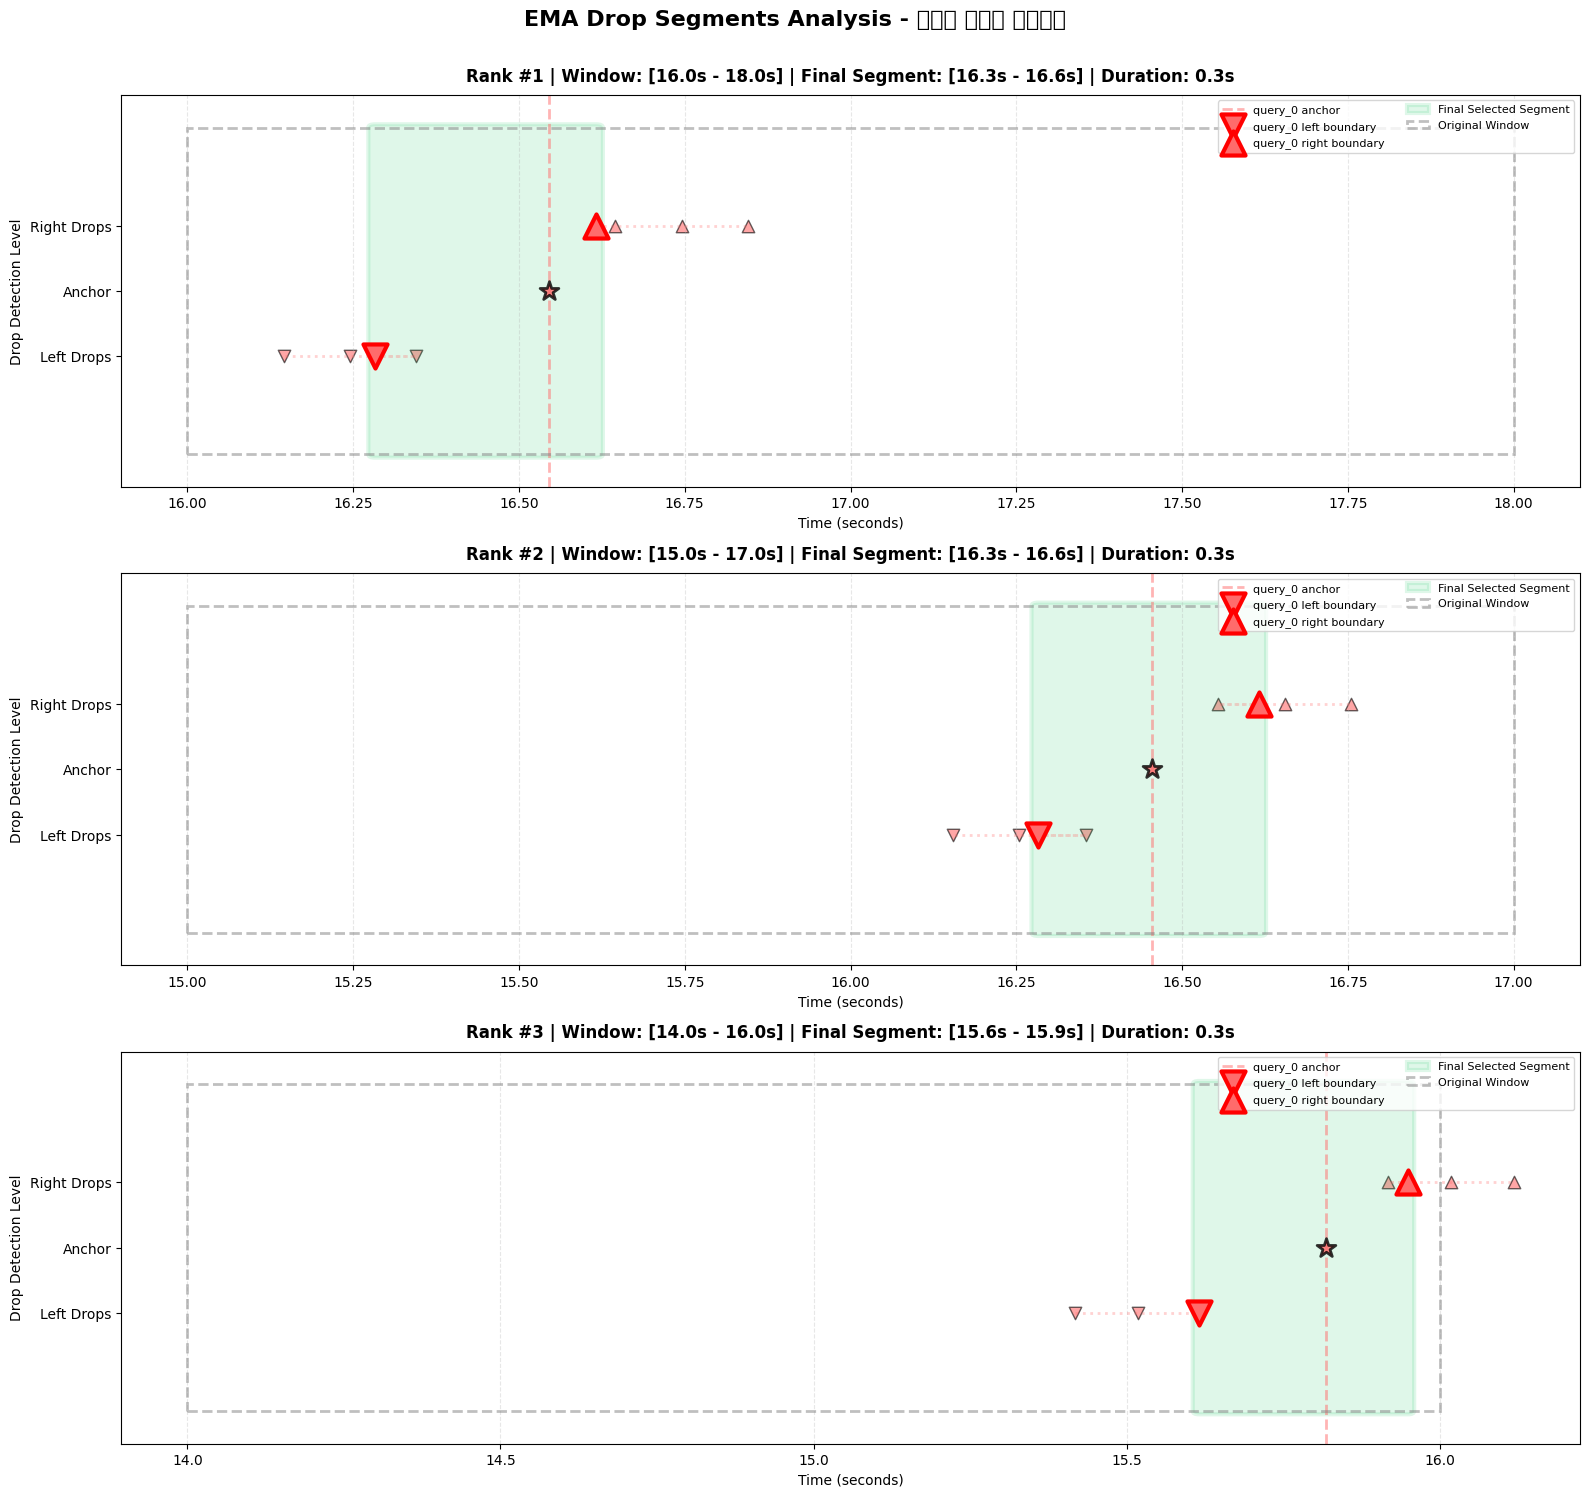

In [ ]:
# ==========================================
# 8. Main Execution
# ==========================================
# ==========================================
# 메모리 관리 헬퍼 함수
# ==========================================
def clear_gpu_memory():
    """GPU 메모리 정리"""
    import torch
    import gc

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

def print_gpu_memory():
    """현재 GPU 메모리 사용량 출력"""
    import torch

    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / 1024**3
        reserved = torch.cuda.memory_reserved(0) / 1024**3
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"  [GPU 메모리] 사용: {allocated:.2f}GB / 예약: {reserved:.2f}GB / 전체: {total:.2f}GB")



def main():
    # 전역 변수 선언 (함수 안에서 전역 변수를 사용/수정하기 위해 필요)
    global model_manager, video_processor

    # 전체 실행 시간 측정 시작
    program_start_time = time.time()

    # --- Configurations ---
    VIDEO_PATH = "/content/YAI_17_Winter_Project/sample_video.mp4" # 준비된 비디오 파일 경로
    SAVE_PATH = "results"
    USE_BLIP = True  # BLIP-2 사용 여부 (메모리 주의)
    if not os.path.exists(SAVE_PATH):
        os.makedirs(SAVE_PATH)
    else:
        print(f"Save path '{SAVE_PATH}' already exists. Results will be saved here.")
    QUERY = "바닥에 떨어진 신용카드"
    # "바닥에 떨어지는 카드를 보고 난감한 표정을 짓는 남자" # 테스트 쿼리

    # Experiments Parameters
    p_list = [2.0, 4.0]      # 윈도우 크기 (초)
    q_list = [12, 24, 48]         # 샘플링 프레임 수
    k_list = [3, 5]          # Top-K 개수
    STEP_SEC = 1.0           # 윈도우 이동 간격 (초) - 윈도우 크기보다 작으면 겹침
    WEIGHT_CLIP = 0.7
    WEIGHT_SEMANTIC = 0.3
    # EMA (전체 프레임 유사도 기반 후처리)
    ENABLE_EMA = True
    EMA_ALPHA = 0.85
    EMA_FRAME_STRIDE = 2  # 1이면 모든 프레임, 2면 2프레임마다
    EMA_BATCH_SIZE = 48
    EMA_MAX_DROP_SEGMENTS = 3
    USE_LOOP = False         # 반복 실행 여부

    # Initialize
    if not os.path.exists(VIDEO_PATH):
        print(f"Error: Video file '{VIDEO_PATH}' not found. Please place a dummy video.")
        return

    # 초기화 시간 측정
    init_start_time = time.time()
    # Initialize (전역 변수로 저장)
    # 이미 초기화되었는지 확인

    # main() 함수 안 (1001줄 앞에 추가)
    print(f"[DEBUG] 'model_manager' in globals(): {'model_manager' in globals()}")
    if 'model_manager' in globals():
        print(f"[DEBUG] model_manager is None: {model_manager is None}")
        print(f"[DEBUG] model_manager 값: {model_manager}")

    if 'model_manager' not in globals() or model_manager is None:
        print("🔄 ModelManager 초기화 중...")
        init_start_time = time.time()
        model_manager = ModelManager(use_blip=USE_BLIP)
        clear_gpu_memory()  # 초기화 후 메모리 정리
        print_gpu_memory()
        print(f"✅ ModelManager 초기화 완료 ({time.time() - init_start_time:.2f}초)")
    else:
        print("♻️ 기존 ModelManager 재사용 (메모리 절약!)")
    if 'video_processor' not in globals() or video_processor is None:
        print("🔄 VideoProcessor 초기화 중...")
        video_processor = VideoProcessor(VIDEO_PATH)
        print(f"✅ VideoProcessor 초기화 완료 ({time.time() - init_start_time:.2f}초)")
    else:
        print("♻️ 기존 VideoProcessor 재사용 (메모리 절약!)")
    engine = AdaptiveSearchEngine(model_manager, video_processor)
    total_init_time = time.time() - init_start_time

    print(f"\n[쿼리 분석] '{QUERY}'")
    sub_queries, split_reason = engine.split_query(QUERY)
    print(f"[분할된 쿼리] {sub_queries}\n")

    # Experiment Loop
    # 반복 실행 할 때
    if USE_LOOP:
        for p in p_list:
            for q in q_list:
                for k in k_list:
                    print(f"\n--- Running Experiment: p={p}, q={q}, k={k} ---")

                    # Perform Search (실시간 시각화 활성화)
                    # 검색 전 메모리 정리
                    clear_gpu_memory()
                    print_gpu_memory()

                    results, all_windows_data, global_frame_scores,visualizer, ema_result = engine.search(QUERY, sub_queries, p, q, k, STEP_SEC, WEIGHT_CLIP, WEIGHT_SEMANTIC, enable_visualization=True, save_path=SAVE_PATH)

                    # EMA 기반 전체 프레임 후처리 (Top-K 앵커 기준)
                    # 🔥 전체 영상 frame score JSON
                    whole_scores = {
                        q: scores
                        for q, scores in global_frame_scores.items()
                    }


                    # 전체 실행 시간 계산
                    total_elapsed_time = time.time() - program_start_time

                    # Construct Filename
                    model_name = "CB" if USE_BLIP else "Clip"
                    timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                    # 유의미한 결과 나왔으면 _test.json 대신 .json 확장자 사용
                    filename = f"{model_name}_{p}, {q}, {k}, {USE_BLIP}, {WEIGHT_CLIP if USE_BLIP else ''}, {WEIGHT_SEMANTIC if USE_BLIP else ''}_{timestamp_str}_test.json"
                    filename_base = f"{model_name}_{p}, {q}, {k}, {USE_BLIP}, {WEIGHT_CLIP if USE_BLIP else ''}, {WEIGHT_SEMANTIC if USE_BLIP else ''}_{timestamp_str}_test"

                    # 시각화 저장
                    if visualizer:
                        try:
                            viz_filename = visualizer.save_and_close(filename_base)
                        except Exception as e:
                            print(f"  [시각화] 저장 실패: {e}")
                            viz_filename = None
                    else:
                        viz_filename = None

                    # 타이밍 정보 수집
                    timing_data = collect_timing_data(total_elapsed_time, total_init_time,
                                                    model_manager, video_processor, engine)

                    # Output Data Structure
                    output_data = {
                        "meta": {
                            "video_path": VIDEO_PATH,
                            "query": QUERY,
                            "sub_queries": sub_queries,
                            "split_reason": split_reason,
                            "parameters": {"p": p, "q": q, "k": k, "USE_BLIP": USE_BLIP, "WEIGHT_CLIP": WEIGHT_CLIP, "WEIGHT_SEMANTIC": WEIGHT_SEMANTIC},
                            "model": model_name,
                            "timestamp": timestamp_str
                        },
                        "time_used": timing_data,
                        "results": results,
                        "ema": ema_result
                    }

                    # Save to JSON
                    with open(os.path.join(SAVE_PATH, filename), "w", encoding='utf-8') as f:
                        json.dump(output_data, f, indent=4, ensure_ascii=False)

                    # 모든 윈도우의 상세 점수 저장
                    whole_score_filename = f"whole_score_{filename}"
                    whole_score_data = {
                        "meta": {
                            "video_path": VIDEO_PATH,
                            "query": QUERY,
                            "sub_queries": sub_queries,
                            "parameters": {"p": p, "q": q, "k": k, "USE_BLIP": USE_BLIP, "WEIGHT_CLIP": WEIGHT_CLIP, "WEIGHT_SEMANTIC": WEIGHT_SEMANTIC},
                            "total_windows": len(all_windows_data),
                            "timestamp": timestamp_str
                        },
                        "all_windows": all_windows_data
                    }
                    with open(os.path.join(SAVE_PATH, whole_score_filename), "w", encoding='utf-8') as f:
                        json.dump(whole_score_data, f, indent=4, ensure_ascii=False)

                    print(f"\n[저장 완료] {filename}")
                    print(f"[상세 점수 저장 완료] {whole_score_filename}")
                    print(f"  -> 총 {len(all_windows_data)}개 윈도우의 상세 점수 저장됨")
                    if viz_filename:
                        print(f"[시각화 저장 완료] {viz_filename}")
                    print(f"[총 실행 시간] {total_elapsed_time:.2f}초\n")
                    cleanup_temp_images(SAVE_PATH)

    # 반복 실행 아닐 때
    else:
         # 검색 전 메모리 정리
         clear_gpu_memory()
         print_gpu_memory()

         results, all_windows_data, global_frame_scores,visualizer, ema_result = engine.search(QUERY, sub_queries, p_list[0], q_list[0], k_list[0], STEP_SEC, WEIGHT_CLIP, WEIGHT_SEMANTIC, enable_visualization=True, save_path=SAVE_PATH)
         # EMA 기반 전체 프레임 후처리 (Top-K 앵커 기준)
         # 🔥 전체 영상 frame score JSON
         whole_scores = {
             q: scores
             for q, scores in global_frame_scores.items()
         }
         # 전체 실행 시간 계산
         total_elapsed_time = time.time() - program_start_time

         model_name = "CB" if USE_BLIP else "Clip"
         timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
         filename = f"{model_name}_{p_list[0]}, {q_list[0]}, {k_list[0]}, {USE_BLIP}, {WEIGHT_CLIP if USE_BLIP else ''}, {WEIGHT_SEMANTIC if USE_BLIP else ''}_{timestamp_str}_test.json"
         filename_base = f"{model_name}_{p_list[0]}, {q_list[0]}, {k_list[0]}, {USE_BLIP}, {WEIGHT_CLIP if USE_BLIP else ''}, {WEIGHT_SEMANTIC if USE_BLIP else ''}_{timestamp_str}_test"

         # 시각화 저장
         if visualizer:
             try:
                 viz_filename = visualizer.save_and_close(filename_base)
             except Exception as e:
                 print(f"  [시각화] 저장 실패: {e}")
                 viz_filename = None
         else:
             viz_filename = None

         # 타이밍 정보 수집
         timing_data = collect_timing_data(total_elapsed_time, total_init_time,
                                        model_manager, video_processor, engine)

         # Output Data Structure
         output_data = {
             "meta": {
                 "video_path": VIDEO_PATH,
                 "query": QUERY,
                 "sub_queries": sub_queries,
                 "split_reason": split_reason,
                 "parameters": {"p": p_list[0], "q": q_list[0], "k": k_list[0], "USE_BLIP": USE_BLIP, "WEIGHT_CLIP": WEIGHT_CLIP, "WEIGHT_SEMANTIC": WEIGHT_SEMANTIC},
                 "model": model_name,
                 "timestamp": timestamp_str
             },
             "time_used": timing_data,
             "results": results,
             "ema": ema_result
         }

         # Save to JSON
         with open(os.path.join(SAVE_PATH, filename), "w", encoding='utf-8') as f:
             json.dump(output_data, f, indent=4, ensure_ascii=False)

         whole_score_filename = f"whole_frame_scores_{filename}"

         with open(os.path.join(SAVE_PATH, whole_score_filename), "w", encoding="utf-8") as f:
             json.dump(whole_scores, f, indent=4, ensure_ascii=False)


         # 모든 윈도우의 상세 점수 저장
         whole_score_filename = f"whole_window_scores_{filename}"
         whole_score_data = {
             "meta": {
                 "video_path": VIDEO_PATH,
                 "query": QUERY,
                 "sub_queries": sub_queries,
                 "parameters": {"p": p_list[0], "q": q_list[0], "k": k_list[0], "USE_BLIP": USE_BLIP, "WEIGHT_CLIP": WEIGHT_CLIP, "WEIGHT_SEMANTIC": WEIGHT_SEMANTIC},
                 "total_windows": len(all_windows_data),
                 "timestamp": timestamp_str
             },
             "all_windows": all_windows_data
         }
         with open(os.path.join(SAVE_PATH, whole_score_filename), "w", encoding='utf-8') as f:
             json.dump(whole_score_data, f, indent=4, ensure_ascii=False)

         print(f"\n{'='*60}")
         print(f"[검색 완료] 결과가 {filename}에 저장되었습니다.")
         print(f"[상세 점수 저장 완료] {whole_score_filename}")
         print(f"  -> 총 {len(all_windows_data)}개 윈도우의 상세 점수 저장됨")
         if viz_filename:
             print(f"[시각화 저장 완료] {viz_filename}")
         print(f"{'='*60}")
         print(f"\n📊 [전체 실행 시간 분석]")
         print(f"{'='*60}")
         print(f"  ⏱️  총 실행 시간: {total_elapsed_time:.2f}초")
         print(f"\n  🔧 초기화 단계:")
         print(f"     - ModelManager 초기화: {model_manager.init_time:.2f}초")
         print(f"       ├─ CLIP 로드: {model_manager.clip_load_time:.2f}초")
         print(f"       └─ BLIP-2 로드: {model_manager.blip_load_time:.2f}초")
         print(f"     - VideoProcessor 초기화: {video_processor.init_time:.2f}초")
         print(f"     - 전체 초기화: {total_init_time:.2f}초")
         print(f"\n  🔍 검색 단계:")
         print(f"     - API 호출 (쿼리 분석): {engine.timing_info['api_call_time']:.2f}초")
         print(f"     - 프레임 추출: {engine.timing_info['frame_extraction_time']:.2f}초")
         print(f"     - CLIP 추론: {engine.timing_info['clip_inference_time']:.2f}초")
         if USE_BLIP:
             print(f"     - BLIP-2 추론: {engine.timing_info['blip_inference_time']:.2f}초")
         print(f"     - 전체 검색: {engine.timing_info['total_search_time']:.2f}초")
         print(f"{'='*60}\n")
         cleanup_temp_images(SAVE_PATH)

if __name__ == "__main__":
    main()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
